# **Project**: Maze Rider

Team member: Hongyu Zhou, Bensalem Souhaiel, Shiyao Li

**Expectation:**

For this project, we require you to do two things:
1. Answer the two questions that you will find below. These questions consist in implementing from scratch both a _Model free tabular RL agent_ and a _Deep Reinforcement Learning_ agent on a relatively simple maze environment.
2. Write a **short** report (2 pages maximum) on your findings, which algorithm worked best, what hyperparameters where key, what hyperparameters were useless.

The following requirements must be met for each projects:
- The deadline for the project is on Friday 3rd March. You should send us a mail with your project attached as a zip before sunday, midnight. Any additional day over the deadline will reduce the final grade by 2 points. Monday 00:01am counts as one day over the deadline.
- Projects should be done in groups of 3, and the following [spreadsheet](https://docs.google.com/spreadsheets/d/1JV6163bd3zZ5JiOQqa8agho7O7UWFkzHc0UMpJs5Y9M/edit?usp=sharing) should be filled to notify us of the groups.
- You can rely as much as you want on the previous practicals, including by copying chunks of code.
- You cannot share code with other groups. Any suspicion of code plagiarism will result in us halving the grade for both groups.

In [1]:
#@title Installation
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[jax]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!pip install dm-haiku
!pip install chex
!pip install imageio
!pip install gym

from IPython.display import clear_output
clear_output()

In [2]:
#@title Imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import time
import numpy as np
from gym import utils
import enum
from typing import *
import chex

import jax
from jax import tree_util
import jax.numpy as jnp
import haiku as hk
import optax

# Environment

For this project, our environment will be a maze. The idea is pretty simple: our agent starts at one end of the maze and must reach a certain goal at the other end. To make things spicier, the agent must also avoid pits scattered in the environment.

At each step the agent can perform one of this four actions: move to the left, to the right, up or down:
- If the agent reaches an empty cell, it gets a reward of $0$.
- If the agent tries to cross a wall, nothing happens and it also gets a reward of $0$.
- If the agent reaches the goal, the episode ends and it gets a reward of $1$.
- If the agent falls into a pit, the episode ends and it gets a reward of $-1$.

The walls will stay the same between each episode, however, the agent's starting position as well as the positions of the goal and the pits will be randomly picked between a small number of candidates at each episode.

In [3]:
# @title **[Skip]** Environment implementation details

Small_TXT_TEMPLATE = """
#######  #######
# SSS #  #PGGGP#
### ###  ##P P##
  # ######## #
  #          #
  ############
---
S=0
G=0
P=.5
"""

Large_TXT_TEMPLATE = """
#########################################
#SSS#     #PPP#S#      #         #G   PP#
#   #GP       # #####  #P  #     #      #
#   ####  #   # #G     #   #GGGGGGGGG   #
#      GGG#   # #      #   ###########  #
###########         #      #            #
#G        #PP     GGGGGG#GG###S      GGG#
#PP  P#   ##################    #########
#######   #      #P                     #
#G               G      #S      P#      #
#########################################
---
S=0
G=0
P=0.5
"""

class CellType(enum.IntEnum):
  WALL = enum.auto()
  PLAYER = enum.auto()
  GOAL = enum.auto()
  PIT = enum.auto()
  EMPTY = enum.auto()

TYPE_TO_CHAR = {
      CellType.WALL: '#',
      CellType.PLAYER: 'S',
      CellType.GOAL: 'G',
      CellType.PIT: 'P',
      CellType.EMPTY: ' ',
  }

def process_template(txt_template: str) -> Tuple[chex.Array, Mapping[str, float]]:
  char_to_type = {v: k for k, v in TYPE_TO_CHAR.items()}
  maze_template, maze_info = txt_template.split("---")
  grid = maze_template.split('\n')
  grid = [l for l in grid if l]
  n_lines, n_cols = len(grid), max(map(len, grid))
  grid = [l + ' ' * (n_cols - len(l)) for l in grid]
  grid = np.array(list(map(lambda x: list(x), grid)))
  mask_pattern = np.array([' '] * len(CellType))
  for k, v in TYPE_TO_CHAR.items():
    mask_pattern[k.value - 1] = v

  grid = grid[:, :, None] == mask_pattern[None, None]
  maze_infos = [list(map(lambda x: x.strip(' '), x.split('='))) for x in maze_info.split('\n') if x]
  maze_infos = {char_to_type[k]: float(v) for k, v in maze_infos}
  return grid, maze_infos

def sample_grid(grid: chex.Array, maze_infos: Mapping[str, float]) -> chex.Array:
  sample = grid.copy()
  for k, v in maze_infos.items():
    layer = grid[..., k.value - 1]
    if v > 0.:
      mask = np.random.binomial(1, v, size=layer.shape)
      sample[..., k.value - 1] = mask * layer
    else:
      idxs = np.nonzero(layer)
      i = np.random.randint(idxs[0].shape[0])
      sample[..., k.value - 1] = np.zeros_like(sample[..., k.value - 1])
      sample[..., k.value - 1][idxs[0][i], idxs[1][i]] = 1

  # For cells that have no values, fill the space layer with 1
  sample[..., CellType.EMPTY.value - 1] = np.maximum(np.all(sample == 0, axis=-1), sample[..., CellType.EMPTY.value - 1])
  return sample

def to_string(grid: chex.Array) -> str:
  mask_pattern = np.array([' '] * len(CellType))
  for k, v in TYPE_TO_CHAR.items():
    mask_pattern[k.value - 1] = v
  str_grid = mask_pattern[grid.argmax(axis=-1)]
  str_grid = '\n'.join(map(lambda x: ''.join(x), str_grid))
  return str_grid

Read the following definition of the `Maze` environment, so that you get an idea of what you have access to in the environment.

In [4]:
# @title **[Read]** Environment definition

class Maze:
  """Definition of the Maze environment.

  You do not need to read this class implementation in detail, you should
  just have a look at its different methods, to see what properties of the
  environment you can access.
  """
  def __init__(self, txt_template: str) -> None:
    self._grid_template, self._maze_infos = process_template(txt_template)

  def reset(self) -> chex.Array:
    """Resets the environment."""
    self._grid = sample_grid(self._grid_template, self._maze_infos)
    return self._grid

  def step(self, action: int) -> Tuple[chex.Array, float, bool]:
    """Perfoms one step in the environment.

    Args:
      action: index of the action to perform.
    Returns:
      next_state, reward, done

    next_state: next state of the environment.
    reward: reward of the current step.
    done: if True the game has ended.
    """
    n_rows, n_cols, _ = self._grid.shape
    x, y = np.nonzero(self._grid[..., CellType.PLAYER.value - 1])
    x, y = x[0], y[0]
    next_x, next_y = x, y
    if action == 0:
      next_x = max(min(x + 1, n_rows - 1), 0)
    elif action == 1:
      next_x = max(min(x - 1, n_rows - 1), 0)
    elif action == 2:
      next_y = max(min(y + 1, n_cols - 1), 0)
    elif action == 3:
      next_y = max(min(y - 1, n_cols - 1), 0)
    next_cell_type = CellType(self._grid[next_x, next_y].argmax() + 1)
    if next_cell_type is CellType.WALL:
      next_x, next_y = x, y
      reward = 0.
      done = False
    elif next_cell_type is CellType.EMPTY:
      reward = 0.
      done = False
    elif next_cell_type == CellType.PIT:
      reward = -1.
      done = True
    elif next_cell_type == CellType.GOAL:
      reward = 1.
      done = True
    else:
      raise ValueError(f'Unknown next cell type {next_cell_type}, this should not happen.')
    self._grid[..., CellType.PLAYER.value - 1][x, y] = 0
    self._grid[..., CellType.EMPTY.value - 1][x, y] = 1
    self._grid[..., :][next_x, next_y] = 0
    self._grid[..., CellType.PLAYER.value - 1][next_x, next_y] = 1
    return self._grid, reward, done

  def render(self) -> str:
    """Renders the environment as a string."""
    return to_string(self._grid)

  def num_actions(self) -> int:
    """Returns the number of usable actions."""
    return 4

  def obs_shape(self) -> Tuple[int, int]:
    """Returns the shape of the Maze."""
    return self._grid.shape

Use the following cell to interact manually with the environment: launch it and a small command line will appear. The commands **U**, **D**, **L** and **R** will move the agent `S`, try to reach the goal `G` by hand while avoiding the eventual pits `P`.

If, for some reason, you want to stop the episode before its end just enter **STOP** into the command line.

In [ ]:
#@title **[Play with the environment]**
env = Maze(TXT_TEMPLATE)

env.reset()

action_to_int = {
    'D': 0,
    'U': 1,
    'R': 2,
    'L': 3,
}

# To stop the game, enter this commandr
STOP_GAME = 'STOP'

while True:
  print(env.render())
  while True:
    action = input().upper()
    if action in ['U', 'D', 'L', 'R', STOP_GAME]:
      break
  if action == STOP_GAME:
    break
  _, reward, done = env.step(action_to_int[action])
  print(f'-----\nReward: {reward}\n-----\n')
  if done:
    break

#######  #######
# S   #  #  G P#
### ###  ##P P##
  # ######## #  
  #          #  
  ############  
STOP


In [ ]:
environment = Maze(Small_TXT_TEMPLATE)
state = environment.reset()
print(state.shape)
print(state[:, :, 3])

(6, 16, 5)
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False  True False
  False False False False]
 [False False False False False False False False False False False  True
  False  True False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]


# **[Exercice 1]** Implementing a tabular RL Algorithm.

Your first task is to implement a model free tabular RL algorithm for the maze environment. You can go for either Q-learning or SARSA. Feel free to take inspiration from the other practicals.

## Hashing
As in the DQN practical, the environment state is a `chex.Array`, and it can thus not directly be put in a dictionary. As in this practical, you should implement a `numpy_to_hash` function.

This function should transform each state into something that can be used as a key in a dictionary. Additionally, this function should be invertible (each input is uniquely mapped to one unique output). In other word, this function should not lose any information. Think about all the information that are contained in a state (position of the agent, position of the goal, ...) and try to encode them in a hash in a compact way.

Contrary to what was done in the DQN practical, you do not need to implement a `hash_to_numpy` function that is the inverse of `np_to_hash`.

## Agent API
Your agent must implement the following functions:
- `def act(self, state: chex.Array, eval: bool = False) -> int` a function that takes in an observation and returns the action selected by the agent. `eval=True` means that you should use the learnt policy, `eval=False` means that you should use the acting policy. Depending on your choice of agent, these two policies may or may not differ.
- `def update(self, state: chex.Array, action: int, next_state: chex.Array, reward: float, done: bool) -> None:` a function that takes in a transition and updates the agent policy.


##  Hashing Function

The function `np_to_hash` takes in a `chex.Array` object that represents the current state of the environment. It returns a tuple that contains information about the player's position, the goal position, and the pit locations. <br> The purpose of this function is to create a hash that can be used as a key in a dictionary to store and retrieve Q-values for each state-action pair. <br>
More specifically, the function first retrieves the dimensions of the `chex.Array` object (number of rows, number of columns, and number of channels). It then finds the location of the player and goal in the environment using the indices where the corresponding `CellType` values (i.e., PLAYER and GOAL) are equal to `1`. If no goal is found, then the function returns the player's position as both the player and goal positions. Finally, the function finds the locations of all pits in the environment and returns them as a tuple.<br>

The returned tuple can be used to represent the current state of the environment in a compact way, and can be used as a key in a dictionary to store and look up Q-values associated with each state.





In [5]:
def np_to_hash(state: chex.Array) -> Tuple[int, int, Tuple[int, int], Tuple[Tuple[int, int], ...]]:
    n_rows, n_cols, n_channels = state.shape

    # Find player location
    player_pos = np.where(state[..., 1] == 1)
    player_pos = (player_pos[0][0], player_pos[1][0])

    # Find goal location
    goal_pos = np.where(state[..., 2] == 1)
    if goal_pos[0].size == 0:
        # No goal found, so return player position for both
        goal_pos = player_pos
    else:
        goal_pos = (goal_pos[0][0], goal_pos[1][0])

    # Find pit locations
    pit_x, pit_y = np.where(state[..., 3] == 1)
    pit_locs = list(zip(pit_x, pit_y))
    pit_locs = tuple(pit_locs)
    
    return player_pos, goal_pos

### Testing our hash function

In [ ]:
environment = Maze(Small_TXT_TEMPLATE)
state = environment.reset()
print(environment.render())
np_to_hash(state)

#######  #######
# S   #  # G  P#
### ###  ##P P##
  # ######## #  
  #          #  
  ############  


((1, 2), (1, 11))

## Uniform random policy

`random_policy` is a function that takes in two arguments - `obs`, a state observation of the environment, and `num_actions`, an integer representing the number of possible actions in the environment. The function returns a random integer between `0` and `num_actions` as the action to take in the given state observation. <br>This function is used as a simple baseline policy for agents during training or for evaluation.

In [6]:
def random_policy(obs: chex.Array, num_actions: int) -> chex.Array:
  return np.random.randint(num_actions)

## Tabular RL algorithms

### Q-Learning

The firat algorithm we will be testing is Q-learning. We choose to test Q-learning first  as it is known to perform well in many settings, especially in discrete environments with a relatively small number of states and actions. <br> 
Our maze environment is a simple and discrete environment with a small number of states and actions, making Q-learning a reasonable choice to try first. Additionally, Q-learning is a model-free algorithm, which means that it can learn directly from experience without needing to model the environment, which is useful when the environment is complex or unknown.

#### Our Q-Learning agent 

`QLearningAgent` is an implementation of the Q-learning algorithm,  which will try to learn the optimal action-value function Q(s,a) that maps each state-action pair to its expected discounted reward. <br>
The agent's class constructor takes in the environment object `env`, the learning rate `alpha`, discount factor `gamma`, initial exploration rate `epsilon`, the minimum exploration rate `min_epsilon`, and the maximum number of training steps `max_steps`. <br> 

The `act` method selects an action for the given state, according to the exploration-exploitation tradeoff. If `eval` is `False` and the agent chooses to explore (with probability `epsilon`), it selects a random action using the `random_policy` function. Otherwise, the agent selects the action that maximizes the Q-value for the current state

The `update` method updates the Q-values for the current state-action pair based on the observed reward and the maximum Q-value for the next state. It also updates the count for the current state-action pair and decays the exploration rate after each step. 

Finally, the `reset_count` method resets the count dictionary for each state-action pair to zero, and the `decay` method updates the exploration rate based on the number of training steps.

In [ ]:
class QLearningAgent:
  def __init__(self, env: Maze, alpha: float, gamma: float, epsilon: float, min_epsilon = 0.05, max_steps = 50000, reward_shaping = True):
      self._env = env
      self._alpha = alpha
      self._gamma = gamma
      self._epsilon = epsilon
      self._Na = env.num_actions()
      self._q_values = {}
      self._max_epsilon = epsilon
      self._min_epsilon = min_epsilon
      self._step = 0
      self._max_steps = max_steps
      self._count_values = {}
      self._reward_shaping = reward_shaping
  
  def act(self, state: chex.Array, eval: bool = False) -> int:
      state_key = np_to_hash(state)
      if not eval and np.random.rand() < self._epsilon:
          return random_policy(state, self._Na)
      if state_key not in self._q_values:
          return random_policy(state, self._Na) 
      return np.argmax(self._q_values[state_key])
  
  def update(self, state: chex.Array, action: int, next_state: chex.Array, reward: float, done: bool) -> None:
      state_key = np_to_hash(state)
      next_state_key = np_to_hash(next_state)
      #reward shaping
      if self._reward_shaping:
        if np.all(state_key == next_state_key):
            reward -= 5
        if state_key not in self._count_values:
            self._count_values[state_key] = np.zeros(self._env.num_actions()) 
        reward -= self._count_values[state_key][action]/(self._count_values[state_key][action]+4)
        self._count_values[state_key][action] += 1

      if state_key not in self._q_values:
          self._q_values[state_key] = np.zeros(self._env.num_actions()) 
      if next_state_key not in self._q_values:
          self._q_values[next_state_key] = np.zeros(self._env.num_actions())
      self._q_values[state_key][action] = (1 - self._alpha) * self._q_values[state_key][action] \
                          + self._alpha * (reward + self._gamma * np.max(self._q_values[next_state_key]) * (1-done))  
  def reset_count(self):
      self._count_values = {}

  def decay(self):
      self._step += 1 
      self._epsilon = self._max_epsilon - self._step * (self._max_epsilon - self._min_epsilon)/self._max_steps

#### Small environment 

We start our parameters study using the small Maze template.

##### Studying the effect of the learning rate $\alpha$

The learning rate determines the weight given to the new information that is acquired during learning, compared to the previously learned information.

If the learning rate is too high, the agent will be highly responsive to new information and will quickly converge to a solution. However, this can lead to instability, as the agent may overshoot and diverge from the optimal policy. On the other hand, if the learning rate is too low, the agent will be slow to learn and may get stuck in suboptimal policies.

$⟹$ Therefore, it is crucial to choose an appropriate learning rate that balances the trade-off between learning speed and stability. By studying the effect of learning rate, we can identify the optimal range of learning rates that results in fast and stable learning.

 alpha = 0.01
Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.8
	200	|	0.3
	300	|	0.8
	400	|	0.9
	500	|	1.0
	600	|	0.9
	700	|	0.6
	800	|	0.9
	900	|	1.0
	1000	|	1.0
	1100	|	0.9
	1200	|	0.8
	1300	|	0.8
	1400	|	1.0
	1500	|	0.8
	1600	|	1.0
	1700	|	0.9
	1800	|	1.0
	1900	|	1.0
	2000	|	1.0
	2100	|	1.0
	2200	|	1.0
	2300	|	1.0
	2400	|	1.0
	2500	|	1.0
	2600	|	1.0
	2700	|	1.0
	2800	|	1.0
	2900	|	1.0
	3000	|	1.0
	3100	|	1.0
	3200	|	1.0
	3300	|	1.0
	3400	|	1.0
	3500	|	1.0
	3600	|	1.0
	3700	|	1.0
	3800	|	1.0
	3900	|	1.0
	4000	|	1.0
	4100	|	1.0
	4200	|	1.0
	4300	|	1.0
	4400	|	1.0
	4500	|	1.0
	4600	|	1.0
	4700	|	1.0
	4800	|	1.0
	4900	|	1.0
	5000	|	1.0
	5100	|	1.0
	5200	|	1.0
	5300	|	1.0
	5400	|	1.0
	5500	|	1.0
	5600	|	1.0
	5700	|	1.0
	5800	|	1.0
	5900	|	1.0
	6000	|	1.0
	6100	|	1.0
	6200	|	1.0
	6300	|	1.0
	6400	|	1.0
	6500	|	1.0
	6600	|	1.0
	6700	|	1.0
	6800	|	1.0
	6900	|	1.0
	7000	|	1.0
	7100	|	1.0
	7200	|	1.0
	7300	|	1.0
	

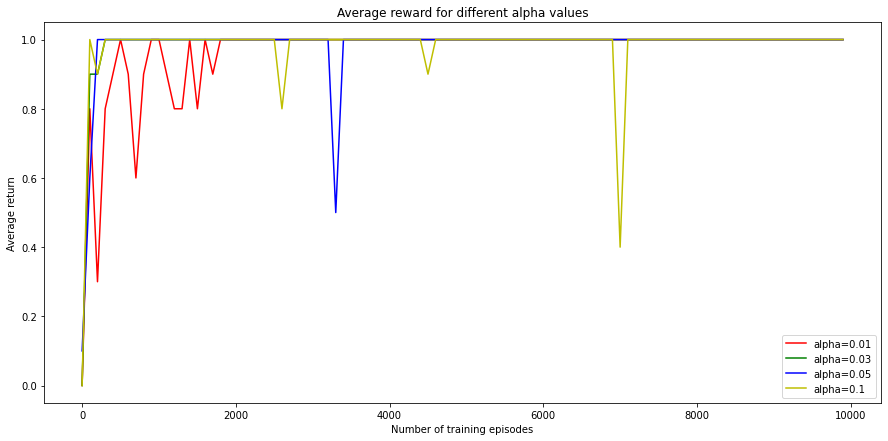

In [ ]:
import matplotlib.pyplot as plt
eps = 0.15 # fixed epsilon value
alphas = [0.01, 0.03, 0.05, 0.1] # range of alpha values to test

num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Small_TXT_TEMPLATE)
Na = environment.num_actions()

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward


alphas = [0.01, 0.03, 0.05, 0.1]
epsilons = [0.1, 0.15, 0.25,0.35]
colors = ['r', 'g', 'b','y']

all_rewards = []

plt.figure(figsize=(15, 7))

for alpha, color in zip(alphas, colors):
    agent = QLearningAgent(environment, gamma=0.9, alpha=alpha, epsilon=eps, max_steps=num_episodes)
    rewards = []
    print(f" alpha = {alpha}")
    print("Episode number:\t| Average reward on 100 eval episodes")
    print("------------------------------------------------------")
    episodes = []
    for episode in range(num_episodes):
        run_episode(agent, environment, max_steps=2000, eval=False)
        agent.decay()

        if episode % eval_every_N == 0:
            reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
            print(f"\t{episode}\t|\t{reward}")
            rewards.append(reward)
            episodes.append(episode)

    plt.plot(episodes,rewards, color=color, label=f'alpha={alpha}')

plt.title('Average reward for different alpha values')
plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.legend()
plt.show()

In this experience we fix $\gamma = 0.9$ (most widely used value for discount factor) and $\epsilon = 0.15$ with the intuition that  since our environment is small, our agent does not need to explore too much. <br>
We can clearly see that choosing a too small learning rate (e.g $\alpha = 0.001$) can result in a slow convergence as the rewards converges approximatively after 2000 episodes  whereas choosing a large learning rate (e.g. $\alpha = 0.1 $ ) can lead to a fast but unstable converge as we can see that the reward occasionally deviates in an abrupt manner from the optimal value of 1 after convergence. <br> 

$\Longrightarrow$ In this case, $\alpha = 0.03$ is the best learning rate as it leads to a stable and fast convergence after only 200 episodes. 

##### Studying the effect of the value of the (maximum) exploration probabilty parameter $\epsilon$

Epsilon is a hyperparameter that controls the degree of exploration, which refers to taking random actions instead of following the optimal policy, and exploitation, which refers to following the policy that maximizes the expected reward based on the learned Q-values. The choice of epsilon is crucial as it affects how quickly the agent can converge to the optimal policy and how robust the learned policy is to changes in the environment or the initial conditions. If epsilon is set too high, the agent will spend too much time exploring and may not converge to an optimal policy. On the other hand, if epsilon is set too low, the agent may get stuck in a suboptimal policy and fail to explore other potential options. Therefore, it is important to study the effect of epsilon and choose an appropriate value to balance exploration and exploitation.

 epsilon_max = 0.1
Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	-0.4
	100	|	0.9
	200	|	0.6
	300	|	0.8
	400	|	0.8
	500	|	0.9
	600	|	1.0
	700	|	1.0
	800	|	1.0
	900	|	1.0
	1000	|	1.0
	1100	|	1.0
	1200	|	1.0
	1300	|	1.0
	1400	|	1.0
	1500	|	1.0
	1600	|	1.0
	1700	|	1.0
	1800	|	1.0
	1900	|	1.0
	2000	|	1.0
	2100	|	1.0
	2200	|	1.0
	2300	|	1.0
	2400	|	1.0
	2500	|	1.0
	2600	|	1.0
	2700	|	1.0
	2800	|	1.0
	2900	|	1.0
	3000	|	1.0
	3100	|	1.0
	3200	|	1.0
	3300	|	1.0
	3400	|	1.0
	3500	|	1.0
	3600	|	1.0
	3700	|	1.0
	3800	|	1.0
	3900	|	1.0
	4000	|	1.0
	4100	|	1.0
	4200	|	1.0
	4300	|	1.0
	4400	|	1.0
	4500	|	1.0
	4600	|	1.0
	4700	|	1.0
	4800	|	1.0
	4900	|	1.0
	5000	|	1.0
	5100	|	1.0
	5200	|	1.0
	5300	|	1.0
	5400	|	1.0
	5500	|	1.0
	5600	|	1.0
	5700	|	1.0
	5800	|	1.0
	5900	|	1.0
	6000	|	1.0
	6100	|	1.0
	6200	|	1.0
	6300	|	1.0
	6400	|	1.0
	6500	|	1.0
	6600	|	1.0
	6700	|	1.0
	6800	|	1.0
	6900	|	1.0
	7000	|	1.0
	7100	|	1.0
	7200	|	1.0
	7300	|

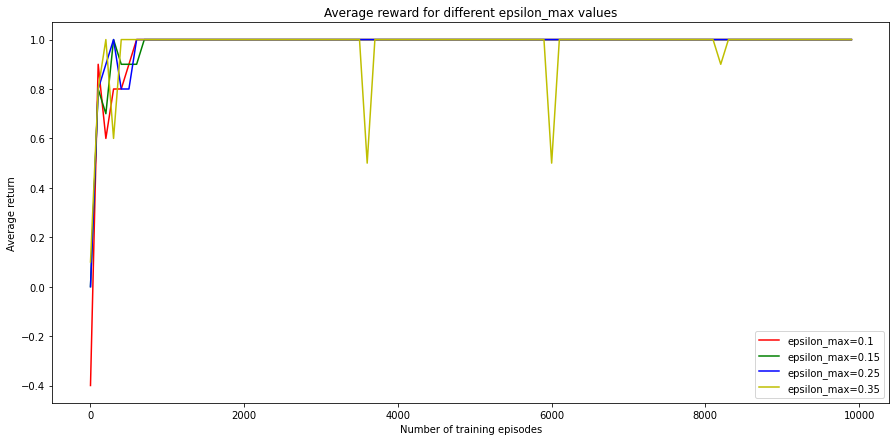

In [ ]:
import matplotlib.pyplot as plt
alpha = 0.03 # fixed alpha value
epsilons = [0.1, 0.15, 0.25,0.35] # range of alpha values to test
colors = ['r', 'g', 'b','y']
num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Small_TXT_TEMPLATE)
Na = environment.num_actions()

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward




all_rewards = []

plt.figure(figsize=(15, 7))

for eps, color in zip(epsilons, colors):
    agent = QLearningAgent(environment, gamma=0.9, alpha=0.03, epsilon= eps, max_steps=num_episodes)
    rewards = []
    print(f" epsilon_max = {eps}")
    print("Episode number:\t| Average reward on 100 eval episodes")
    print("------------------------------------------------------")
    episodes = []
    for episode in range(num_episodes):
        run_episode(agent, environment, max_steps=2000, eval=False)
        agent.decay()

        if episode % eval_every_N == 0:
            reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
            print(f"\t{episode}\t|\t{reward}")
            rewards.append(reward)
            episodes.append(episode)

    plt.plot(episodes,rewards, color=color, label=f'epsilon_max={eps}')

plt.title('Average reward for different epsilon_max values')
plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.legend()
plt.show()

In this experiment, we fixed $\alpha = 0.03$ which the best value according to our previous experiment. Here we notice that choosing a high value for $\epsilon$ (e.g. $\epsilon = 0.35$) i.e. exploring a lot in this small environment leads to an unstable convergence as a  the agent may sometimes take random actions that lead to lower rewards even though it has already learned a good policy. This can cause the reward to oscillate even after convergence, as the agent continues to explore and take random actions that lead to lower rewards. On the other hand, choosing a loer value leads to a more stable convergence.

##### Running our agent using the best combination i.e. $\alpha=0.03$ and $\epsilon = 0.15$

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	-0.4
	100	|	0.5
	200	|	0.9
	300	|	1.0
	400	|	1.0
	500	|	1.0
	600	|	1.0
	700	|	1.0
	800	|	1.0
	900	|	1.0
	1000	|	1.0
	1100	|	1.0
	1200	|	1.0
	1300	|	1.0
	1400	|	1.0
	1500	|	1.0
	1600	|	1.0
	1700	|	1.0
	1800	|	1.0
	1900	|	1.0
	2000	|	1.0
	2100	|	1.0
	2200	|	1.0
	2300	|	1.0
	2400	|	1.0
	2500	|	1.0
	2600	|	1.0
	2700	|	1.0
	2800	|	1.0
	2900	|	1.0
	3000	|	1.0
	3100	|	1.0
	3200	|	1.0
	3300	|	1.0
	3400	|	1.0
	3500	|	1.0
	3600	|	1.0
	3700	|	1.0
	3800	|	1.0
	3900	|	1.0
	4000	|	1.0
	4100	|	1.0
	4200	|	1.0
	4300	|	1.0
	4400	|	1.0
	4500	|	1.0
	4600	|	1.0
	4700	|	1.0
	4800	|	1.0
	4900	|	1.0
	5000	|	1.0
	5100	|	1.0
	5200	|	1.0
	5300	|	1.0
	5400	|	1.0
	5500	|	1.0
	5600	|	1.0
	5700	|	1.0
	5800	|	1.0
	5900	|	1.0
	6000	|	1.0
	6100	|	1.0
	6200	|	1.0
	6300	|	1.0
	6400	|	1.0
	6500	|	1.0
	6600	|	1.0
	6700	|	1.0
	6800	|	1.0
	6900	|	1.0
	7000	|	1.0
	7100	|	1.0
	7200	|	1.0
	7300	|	1.0
	7400	|	1.0
	7

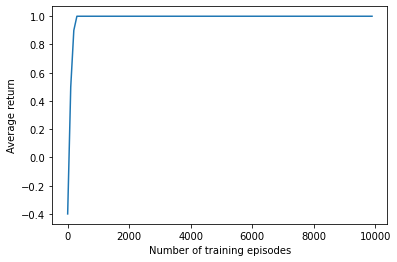

In [ ]:
import matplotlib.pyplot as plt


num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Small_TXT_TEMPLATE)
Na = environment.num_actions()

# Define your QLearningAgent here
 
agent = QLearningAgent(environment, gamma=0.9, alpha=0.03, epsilon=0.15, max_steps = num_episodes)
all_rewards = []
episodes = []

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward
#plt.figure(figsize=(15, 7))
print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
  run_episode(agent, environment, max_steps = 2000, eval=False)
  agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_episode(agent, environment, eval=True, render = False) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

For our chosen parameters, our agent is able to learn an optimal policy after roughly 500 episodes. This result is expected since our Maze environment is quite simple and small in size

In [ ]:
run_episode(agent, environment, eval=True, render=True)

Step: 0
#######  #######
#  S  #  #   G #
### ###  ##P  ##
  # ######## #  
  #          #  
  ############  
Step: 1
#######  #######
#     #  #   G #
###S###  ##P  ##
  # ######## #  
  #          #  
  ############  
Step: 2
#######  #######
#     #  #   G #
### ###  ##P  ##
  #S######## #  
  #          #  
  ############  
Step: 3
#######  #######
#     #  #   G #
### ###  ##P  ##
  # ######## #  
  #S         #  
  ############  
Step: 4
#######  #######
#     #  #   G #
### ###  ##P  ##
  # ######## #  
  # S        #  
  ############  
Step: 5
#######  #######
#     #  #   G #
### ###  ##P  ##
  # ######## #  
  #  S       #  
  ############  
Step: 6
#######  #######
#     #  #   G #
### ###  ##P  ##
  # ######## #  
  #   S      #  
  ############  
Step: 7
#######  #######
#     #  #   G #
### ###  ##P  ##
  # ######## #  
  #    S     #  
  ############  
Step: 8
#######  #######
#     #  #   G #
### ###  ##P  ##
  # ######## #  
  #     S    #  
  ############  
Step: 9
##

1.0

##### Study the effect of reward shaping

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.0
	200	|	0.5
	300	|	0.2
	400	|	0.4
	500	|	0.5
	600	|	0.6
	700	|	0.6
	800	|	0.7
	900	|	0.7
	1000	|	0.6
	1100	|	0.7
	1200	|	0.7
	1300	|	0.3
	1400	|	0.4
	1500	|	0.5
	1600	|	0.4
	1700	|	0.5
	1800	|	0.8
	1900	|	0.7
	2000	|	0.6
	2100	|	0.7
	2200	|	0.6
	2300	|	0.6
	2400	|	0.7
	2500	|	0.5
	2600	|	0.3
	2700	|	0.4
	2800	|	0.6
	2900	|	0.6
	3000	|	0.6
	3100	|	0.6
	3200	|	0.7
	3300	|	0.8
	3400	|	0.6
	3500	|	0.8
	3600	|	0.7
	3700	|	0.7
	3800	|	0.7
	3900	|	0.5
	4000	|	0.9
	4100	|	0.6
	4200	|	0.7
	4300	|	0.6
	4400	|	0.6
	4500	|	0.7
	4600	|	0.8
	4700	|	0.4
	4800	|	0.6
	4900	|	0.6
	5000	|	0.8
	5100	|	0.8
	5200	|	0.6
	5300	|	0.6
	5400	|	0.7
	5500	|	0.7
	5600	|	0.7
	5700	|	0.7
	5800	|	0.5
	5900	|	0.6
	6000	|	0.8
	6100	|	0.8
	6200	|	0.6
	6300	|	0.8
	6400	|	0.5
	6500	|	0.5
	6600	|	0.6
	6700	|	0.7
	6800	|	0.9
	6900	|	0.7
	7000	|	0.6
	7100	|	0.9
	7200	|	0.4
	7300	|	0.6
	7400	|	1.0
	75

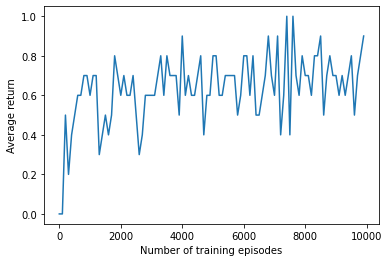

In [ ]:
import matplotlib.pyplot as plt


num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Small_TXT_TEMPLATE)
Na = environment.num_actions()

# Define your QLearningAgent here
 
agent = QLearningAgent(environment, gamma=0.9, alpha=0.03, epsilon=0.15, max_steps = num_episodes, reward_shaping = False)
all_rewards = []
episodes = []

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward
#plt.figure(figsize=(15, 7))
print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
  run_episode(agent, environment, max_steps = 2000, eval=False)
  agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_episode(agent, environment, eval=True, render = False) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

#### Large Maze

Now we will be shift our attention to the Large Maze environment. This is a more complex and challenging problem for the agent to solve. The larger size of the maze would require the agent to explore a larger state space, and thus would require a more sophisticated learning algorithm to navigate efficiently. Additionally, the Large Maze environment could be used as a benchmark to test the performance and scalability of the Q-learning algorithm.  

##### Studying the effect of the learning rate $\alpha$

 alpha = 0.01
Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	-0.8
	100	|	-0.1
	200	|	0.0
	300	|	0.0
	400	|	-0.1
	500	|	0.0
	600	|	0.0
	700	|	0.0
	800	|	0.0
	900	|	0.0
	1000	|	0.0
	1100	|	0.1
	1200	|	0.1
	1300	|	0.2
	1400	|	0.0
	1500	|	0.1
	1600	|	0.1
	1700	|	0.0
	1800	|	0.0
	1900	|	0.0
	2000	|	0.2
	2100	|	0.2
	2200	|	0.0
	2300	|	0.0
	2400	|	0.2
	2500	|	0.2
	2600	|	0.0
	2700	|	0.0
	2800	|	0.1
	2900	|	0.1
	3000	|	0.1
	3100	|	0.1
	3200	|	0.0
	3300	|	0.1
	3400	|	0.2
	3500	|	0.1
	3600	|	-0.1
	3700	|	0.1
	3800	|	0.1
	3900	|	0.3
	4000	|	0.0
	4100	|	0.0
	4200	|	0.1
	4300	|	0.0
	4400	|	0.0
	4500	|	0.3
	4600	|	0.4
	4700	|	0.0
	4800	|	0.1
	4900	|	0.2
	5000	|	0.0
	5100	|	0.3
	5200	|	0.0
	5300	|	0.0
	5400	|	0.2
	5500	|	0.3
	5600	|	0.2
	5700	|	0.1
	5800	|	0.0
	5900	|	0.1
	6000	|	0.0
	6100	|	0.2
	6200	|	0.1
	6300	|	0.1
	6400	|	0.2
	6500	|	0.0
	6600	|	0.3
	6700	|	-0.1
	6800	|	0.2
	6900	|	0.3
	7000	|	0.3
	7100	|	0.2
	7200	|	0.4
	7300	|	

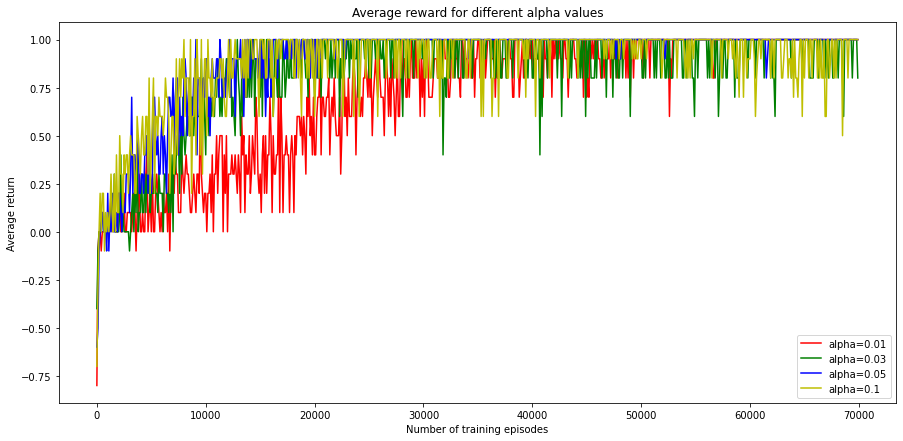

In [ ]:
import matplotlib.pyplot as plt
eps = 0.15 # fixed epsilon value
alphas = [0.01, 0.03, 0.05, 0.1] # range of alpha values to test

num_episodes = 70000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Large_TXT_TEMPLATE)
Na = environment.num_actions()

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward


all_rewards = []

plt.figure(figsize=(15, 7))

for alpha, color in zip(alphas, colors):
    agent = QLearningAgent(environment, gamma=0.9, alpha=alpha, epsilon=eps, max_steps=num_episodes)
    rewards = []
    print(f" alpha = {alpha}")
    print("Episode number:\t| Average reward on 100 eval episodes")
    print("------------------------------------------------------")
    episodes = []
    for episode in range(num_episodes):
        run_episode(agent, environment, max_steps=2000, eval=False)
        agent.decay()

        if episode % eval_every_N == 0:
            reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
            print(f"\t{episode}\t|\t{reward}")
            rewards.append(reward)
            episodes.append(episode)

    plt.plot(episodes,rewards, color=color, label=f'alpha={alpha}')

plt.title('Average reward for different alpha values')
plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.legend()
plt.show()

Just as before, we can observe that different values of alpha lead to different convergence rates and final performances of the Q-learning agent. 

For small values of alpha, the Q-learning agent takes a long time to converge, and the final performance is relatively poor. This is because small values of alpha make the agent update its Q-values slowly, which leads to slow convergence. On the other hand, large values of alpha lead to faster convergence, but the agent may overshoot and converge to sub-optimal values. Therefore, it is essential to choose an optimal learning rate that balances the convergence speed and final performance of the agent.

In the case of our maze environment, we can observe that the optimal value of alpha is around 0.03, however we will be using a value of 0.02 to try and stabilize the learning more. Values below this lead to slow convergence, and values above this may lead to sub-optimal performance.

##### Studying the effect of the value of the (maximum) exploration probabilty parameter $\epsilon$

 epsilon_max = 0.1
Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	-0.4
	100	|	-0.1
	200	|	-0.1
	300	|	0.0
	400	|	0.0
	500	|	0.1
	600	|	0.0
	700	|	0.0
	800	|	0.0
	900	|	0.2
	1000	|	0.1
	1100	|	0.1
	1200	|	0.2
	1300	|	0.2
	1400	|	0.0
	1500	|	0.1
	1600	|	0.2
	1700	|	0.0
	1800	|	0.2
	1900	|	0.1
	2000	|	0.0
	2100	|	0.0
	2200	|	0.0
	2300	|	0.1
	2400	|	0.1
	2500	|	0.2
	2600	|	0.2
	2700	|	0.2
	2800	|	0.3
	2900	|	0.2
	3000	|	0.1
	3100	|	0.2
	3200	|	0.4
	3300	|	0.2
	3400	|	-0.1
	3500	|	-0.1
	3600	|	0.3
	3700	|	0.2
	3800	|	0.5
	3900	|	0.1
	4000	|	0.2
	4100	|	0.1
	4200	|	0.0
	4300	|	0.2
	4400	|	0.0
	4500	|	0.1
	4600	|	0.5
	4700	|	0.0
	4800	|	0.2
	4900	|	0.3
	5000	|	0.2
	5100	|	0.4
	5200	|	0.1
	5300	|	0.3
	5400	|	0.3
	5500	|	0.3
	5600	|	0.4
	5700	|	0.3
	5800	|	0.3
	5900	|	0.4
	6000	|	0.1
	6100	|	0.4
	6200	|	0.2
	6300	|	0.4
	6400	|	0.4
	6500	|	0.4
	6600	|	0.2
	6700	|	0.4
	6800	|	0.4
	6900	|	0.4
	7000	|	0.4
	7100	|	0.4
	7200	|	0.4
	73

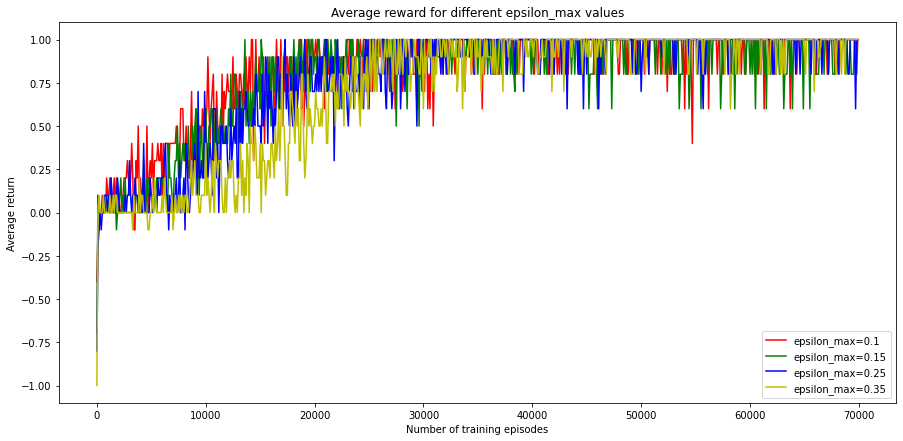

In [ ]:
import matplotlib.pyplot as plt
alpha = 0.02 # fixed alpha value
epsilons = [0.1, 0.15, 0.25,0.35] # range of alpha values to test
colors = ['r', 'g', 'b','y']
num_episodes = 70000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Large_TXT_TEMPLATE)
Na = environment.num_actions()

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward




all_rewards = []

plt.figure(figsize=(15, 7))

for eps, color in zip(epsilons, colors):
    agent = QLearningAgent(environment, gamma=0.9, alpha=alpha, epsilon= eps, max_steps=num_episodes)
    rewards = []
    print(f" epsilon_max = {eps}")
    print("Episode number:\t| Average reward on 100 eval episodes")
    print("------------------------------------------------------")
    episodes = []
    for episode in range(num_episodes):
        run_episode(agent, environment, max_steps=2000, eval=False)
        agent.decay()

        if episode % eval_every_N == 0:
            reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
            print(f"\t{episode}\t|\t{reward}")
            rewards.append(reward)
            episodes.append(episode)

    plt.plot(episodes,rewards, color=color, label=f'epsilon_max={eps}')

plt.title('Average reward for different epsilon_max values')
plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.legend()
plt.show()

##### Running our agent using the best combination i.e. $\alpha=0.02$ and $\epsilon = 0.25$

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	-0.8
	100	|	-0.2
	200	|	0.0
	300	|	0.0
	400	|	0.0
	500	|	0.0
	600	|	-0.1
	700	|	0.0
	800	|	0.0
	900	|	0.0
	1000	|	0.1
	1100	|	0.1
	1200	|	0.0
	1300	|	0.0
	1400	|	0.1
	1500	|	0.0
	1600	|	0.0
	1700	|	0.0
	1800	|	0.1
	1900	|	0.0
	2000	|	0.0
	2100	|	0.0
	2200	|	0.0
	2300	|	0.0
	2400	|	0.0
	2500	|	0.0
	2600	|	0.0
	2700	|	0.0
	2800	|	0.1
	2900	|	0.2
	3000	|	0.2
	3100	|	0.0
	3200	|	0.1
	3300	|	0.2
	3400	|	0.1
	3500	|	0.2
	3600	|	0.1
	3700	|	0.0
	3800	|	0.1
	3900	|	0.1
	4000	|	0.0
	4100	|	0.0
	4200	|	0.1
	4300	|	0.0
	4400	|	-0.1
	4500	|	0.0
	4600	|	0.0
	4700	|	0.0
	4800	|	0.0
	4900	|	0.0
	5000	|	0.2
	5100	|	0.0
	5200	|	0.0
	5300	|	0.0
	5400	|	0.1
	5500	|	0.0
	5600	|	0.0
	5700	|	0.1
	5800	|	0.0
	5900	|	0.2
	6000	|	0.2
	6100	|	0.0
	6200	|	0.2
	6300	|	0.1
	6400	|	0.3
	6500	|	0.1
	6600	|	0.1
	6700	|	0.5
	6800	|	0.2
	6900	|	0.1
	7000	|	0.2
	7100	|	0.3
	7200	|	0.2
	7300	|	0.1
	7400	|	0.1

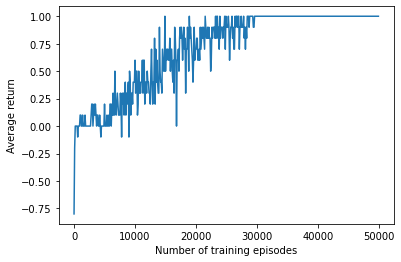

In [ ]:
 
import matplotlib.pyplot as plt


num_episodes = 50000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Large_TXT_TEMPLATE)
Na = environment.num_actions()

# Define your QLearningAgent here
 
agent = QLearningAgent(environment, gamma=0.9, alpha=0.02, epsilon=0.25, max_steps = num_episodes)
all_rewards = []
episodes = []

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
  run_episode(agent, environment, max_steps = 2000, eval=False)
  agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_episode(agent, environment, eval=True, render = False) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

  Our reward signal converges after almost 30000 episodes which is much more slower than forr the small Maze template due to the large state space and the sparse reward structure. 

##### Show one trajectory

In [ ]:
run_episode(agent, environment, eval=True, render=True)

Step: 0
#########################################
#   #     #   # #      #         #    PP#
#   #         # #####  #P  #     #      #
#   ####  #   # #      #   #        G   #
#         #   # #      #   ###########  #
###########         #      #            #
#         #             #  ###          #
#PP  P#   ##################    #########
#######   #      #                      #
#                       #S       #      #
#########################################
Step: 1
#########################################
#   #     #   # #      #         #    PP#
#   #         # #####  #P  #     #      #
#   ####  #   # #      #   #        G   #
#         #   # #      #   ###########  #
###########         #      #            #
#         #             #  ###          #
#PP  P#   ##################    #########
#######   #      #       S              #
#                       #        #      #
#########################################
Step: 2
#########################################
#   #     

1.0

### Double - Q learning agent : 

The Double Q-Learning agent is a variant of the Q-learning algorithm that tries to address the problem of overestimation of Q-values, which can occur in standard Q-learning when the agent learns from its own estimates of Q-values. The idea behind Double Q-Learning is to maintain two separate Q-value functions (Q1 and Q2) and use them to update the current state-action value alternately.

The agent acts according to the sum of Q1 and Q2 values for each state-action pair. During training, the agent updates the Q-values in a way that one of the functions selects the best action, and the other evaluates this action in the next state. This process is done randomly with a 0.5 probability for each Q-function to be used to update the current state-action value.

Using two separate Q-functions in this way can help to reduce overestimation of Q-values. It prevents the agent from learning from its own estimates of Q-values and instead allows it to use different sources of information for the Q-values. This can lead to more accurate and stable Q-value estimates and can improve the agent's performance in some environments.

Compared to the standard Q-learning agent, the Double Q-Learning agent has the additional complexity of maintaining two separate Q-value functions. However, it can be useful in environments where overestimation of Q-values is a problem.

In [ ]:
class DoubleQLearningAgent:
  def __init__(self, env: Maze, alpha: float, gamma: float, epsilon: float, min_epsilon=0.05, max_steps=50000, reward_shaping = True):
    self._env = env
    self._alpha = alpha
    self._gamma = gamma
    self._epsilon = epsilon
    self._Na = env.num_actions()
    self._q1_values = {}
    self._q2_values = {}
    self._max_epsilon = epsilon
    self._min_epsilon = min_epsilon
    self._step = 0
    self._max_steps = max_steps
    self._count_values = {}
    self._reward_shaping = reward_shaping

  def act(self, state: chex.Array, eval: bool = False) -> int:
    state_key = np_to_hash(state)
    if not eval and np.random.rand() < self._epsilon:
      return random_policy(state, self._Na)
    if state_key not in self._q1_values:
      # Initialize Q-values for the current state if it has not been seen before
      self._q1_values[state_key] = np.zeros(self._env.num_actions())
      self._q2_values[state_key] = np.zeros(self._env.num_actions())
      return random_policy(state, self._Na)
    # Use both Q1 and Q2 values to make action selection
    q_values = self._q1_values[state_key] + self._q2_values[state_key]
    return np.argmax(q_values)

  def update(self, state: chex.Array, action: int, next_state: chex.Array, reward: float, done: bool) -> None:
    state_key = np_to_hash(state)
    next_state_key = np_to_hash(next_state)
    # reward shaping
    if self._reward_shaping: 
      if np.all(state_key == next_state_key):
        reward -= 5
      if state_key not in self._count_values:
        self._count_values[state_key] = np.zeros(self._env.num_actions())
      reward -= self._count_values[state_key][action] / (self._count_values[state_key][action] + 4)
      self._count_values[state_key][action] += 1

    if state_key not in self._q1_values:
      self._q1_values[state_key] = np.zeros(self._env.num_actions())
      self._q2_values[state_key] = np.zeros(self._env.num_actions())
    if next_state_key not in self._q1_values:
      self._q1_values[next_state_key] = np.zeros(self._env.num_actions())
      self._q2_values[next_state_key] = np.zeros(self._env.num_actions())
    # Randomly select which Q-value function to use to update the current state-action value
    if np.random.rand() < 0.5:
      self._q1_values[state_key][action] = (1 - self._alpha) * self._q1_values[state_key][action] \
                                           + self._alpha * (reward + self._gamma * self._q2_values[next_state_key][np.argmax(self._q1_values[next_state_key])] * (1 - done))
    else:
      self._q2_values[state_key][action] = (1 - self._alpha) * self._q2_values[state_key][action] \
                                           + self._alpha * (reward + self._gamma * self._q1_values[next_state_key][np.argmax(self._q2_values[next_state_key])] * (1 - done))

  def reset_count(self):
      self._count_values = {}

  def decay(self):
      self._step += 1 
      self._epsilon = self._max_epsilon - self._step * (self._max_epsilon - self._min_epsilon)/self._max_steps

#### Small Maze environment

##### Studying the effect of the learning rate $\alpha$

 alpha = 0.01
Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.0
	200	|	0.5
	300	|	0.7
	400	|	0.5
	500	|	1.0
	600	|	0.7
	700	|	0.9
	800	|	1.0
	900	|	1.0
	1000	|	1.0
	1100	|	0.9
	1200	|	0.8
	1300	|	1.0
	1400	|	0.7
	1500	|	1.0
	1600	|	1.0
	1700	|	1.0
	1800	|	1.0
	1900	|	0.8
	2000	|	0.9
	2100	|	0.9
	2200	|	0.4
	2300	|	0.8
	2400	|	0.8
	2500	|	1.0
	2600	|	1.0
	2700	|	1.0
	2800	|	1.0
	2900	|	1.0
	3000	|	1.0
	3100	|	1.0
	3200	|	1.0
	3300	|	1.0
	3400	|	1.0
	3500	|	1.0
	3600	|	1.0
	3700	|	1.0
	3800	|	1.0
	3900	|	1.0
	4000	|	1.0
	4100	|	1.0
	4200	|	1.0
	4300	|	1.0
	4400	|	1.0
	4500	|	1.0
	4600	|	1.0
	4700	|	0.7
	4800	|	1.0
	4900	|	1.0
	5000	|	1.0
	5100	|	1.0
	5200	|	1.0
	5300	|	1.0
	5400	|	1.0
	5500	|	1.0
	5600	|	1.0
	5700	|	1.0
	5800	|	1.0
	5900	|	1.0
	6000	|	1.0
	6100	|	1.0
	6200	|	1.0
	6300	|	1.0
	6400	|	1.0
	6500	|	1.0
	6600	|	1.0
	6700	|	1.0
	6800	|	1.0
	6900	|	1.0
	7000	|	1.0
	7100	|	1.0
	7200	|	1.0
	7300	|	1.0
	

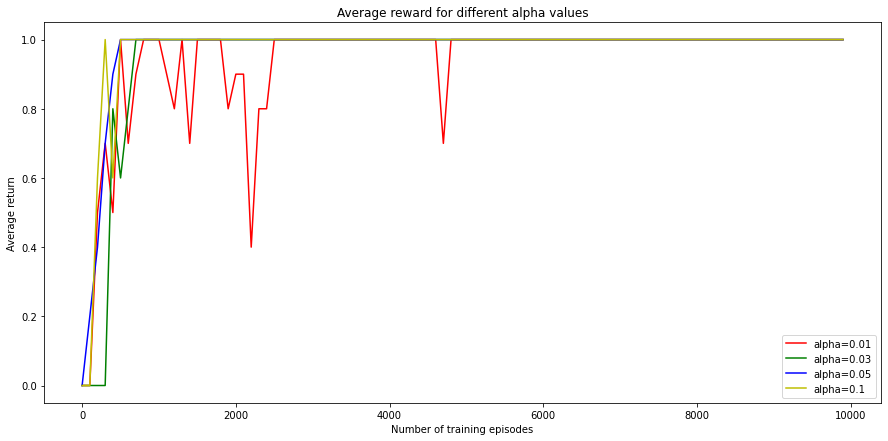

In [ ]:
import matplotlib.pyplot as plt
eps = 0.15 # fixed epsilon value
alphas = [0.01, 0.03, 0.05, 0.1] # range of alpha values to test

num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Small_TXT_TEMPLATE)
Na = environment.num_actions()

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward


 

all_rewards = []

plt.figure(figsize=(15, 7))

for alpha, color in zip(alphas, colors):
    agent = DoubleQLearningAgent(environment, gamma=0.9, alpha=alpha, epsilon=eps, max_steps=num_episodes)
    rewards = []
    print(f" alpha = {alpha}")
    print("Episode number:\t| Average reward on 100 eval episodes")
    print("------------------------------------------------------")
    episodes = []
    for episode in range(num_episodes):
        run_episode(agent, environment, max_steps=2000, eval=False)
        agent.decay()

        if episode % eval_every_N == 0:
            reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
            print(f"\t{episode}\t|\t{reward}")
            rewards.append(reward)
            episodes.append(episode)

    plt.plot(episodes,rewards, color=color, label=f'alpha={alpha}')

plt.title('Average reward for different alpha values')
plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.legend()
plt.show()

$⟹$ We pick $\alpha = 0.03$ 

##### Studying the effect of the value of the (maximum) exploration probabilty parameter $\epsilon$

 epsilon_max = 0.1
Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.0
	200	|	0.3
	300	|	0.4
	400	|	0.0
	500	|	0.5
	600	|	0.7
	700	|	0.9
	800	|	0.9
	900	|	1.0
	1000	|	1.0
	1100	|	0.8
	1200	|	1.0
	1300	|	1.0
	1400	|	1.0
	1500	|	1.0
	1600	|	1.0
	1700	|	1.0
	1800	|	1.0
	1900	|	1.0
	2000	|	1.0
	2100	|	1.0
	2200	|	1.0
	2300	|	1.0
	2400	|	1.0
	2500	|	1.0
	2600	|	1.0
	2700	|	1.0
	2800	|	1.0
	2900	|	1.0
	3000	|	1.0
	3100	|	1.0
	3200	|	1.0
	3300	|	1.0
	3400	|	1.0
	3500	|	1.0
	3600	|	1.0
	3700	|	1.0
	3800	|	1.0
	3900	|	1.0
	4000	|	1.0
	4100	|	1.0
	4200	|	1.0
	4300	|	1.0
	4400	|	1.0
	4500	|	1.0
	4600	|	1.0
	4700	|	1.0
	4800	|	1.0
	4900	|	1.0
	5000	|	1.0
	5100	|	1.0
	5200	|	1.0
	5300	|	1.0
	5400	|	1.0
	5500	|	1.0
	5600	|	1.0
	5700	|	1.0
	5800	|	1.0
	5900	|	1.0
	6000	|	1.0
	6100	|	1.0
	6200	|	1.0
	6300	|	1.0
	6400	|	1.0
	6500	|	1.0
	6600	|	1.0
	6700	|	1.0
	6800	|	1.0
	6900	|	1.0
	7000	|	1.0
	7100	|	1.0
	7200	|	1.0
	7300	|	

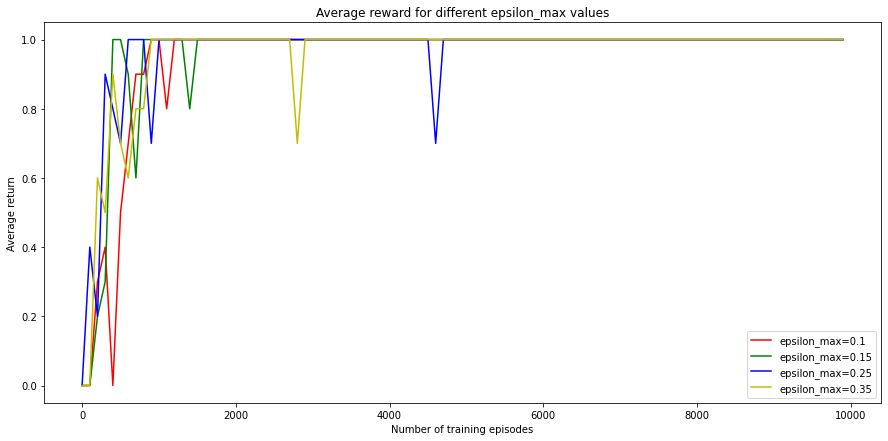

In [ ]:
import matplotlib.pyplot as plt
alpha = 0.03 # fixed alpha value
epsilons = [0.1, 0.15, 0.25,0.35] # range of alpha values to test
colors = ['r', 'g', 'b','y']
num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Small_TXT_TEMPLATE)
Na = environment.num_actions()

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward




all_rewards = []

plt.figure(figsize=(15, 7))

for eps, color in zip(epsilons, colors):
    agent = DoubleQLearningAgent(environment, gamma=0.9, alpha=alpha, epsilon=eps, max_steps=num_episodes)
    rewards = []
    print(f" epsilon_max = {eps}")
    print("Episode number:\t| Average reward on 100 eval episodes")
    print("------------------------------------------------------")
    episodes = []
    for episode in range(num_episodes):
        run_episode(agent, environment, max_steps=2000, eval=False)
        agent.decay()

        if episode % eval_every_N == 0:
            reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
            print(f"\t{episode}\t|\t{reward}")
            rewards.append(reward)
            episodes.append(episode)

    plt.plot(episodes,rewards, color=color, label=f'epsilon_max={eps}')

plt.title('Average reward for different epsilon_max values')
plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.legend()
plt.show()

⟹ We pick  $\epsilon =0.15$

##### Running our agent using the best combination i.e. $\alpha=0.03$ and $\epsilon = 0.15$

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.0
	200	|	0.0
	300	|	0.0
	400	|	0.3
	500	|	0.7
	600	|	0.7
	700	|	0.9
	800	|	1.0
	900	|	1.0
	1000	|	1.0
	1100	|	1.0
	1200	|	1.0
	1300	|	1.0
	1400	|	1.0
	1500	|	1.0
	1600	|	1.0
	1700	|	1.0
	1800	|	1.0
	1900	|	1.0
	2000	|	1.0
	2100	|	1.0
	2200	|	1.0
	2300	|	1.0
	2400	|	1.0
	2500	|	1.0
	2600	|	1.0
	2700	|	1.0
	2800	|	1.0
	2900	|	1.0
	3000	|	1.0
	3100	|	1.0
	3200	|	1.0
	3300	|	1.0
	3400	|	1.0
	3500	|	1.0
	3600	|	1.0
	3700	|	1.0
	3800	|	1.0
	3900	|	1.0
	4000	|	1.0
	4100	|	1.0
	4200	|	1.0
	4300	|	1.0
	4400	|	1.0
	4500	|	1.0
	4600	|	1.0
	4700	|	1.0
	4800	|	1.0
	4900	|	1.0
	5000	|	1.0
	5100	|	1.0
	5200	|	1.0
	5300	|	1.0
	5400	|	1.0
	5500	|	1.0
	5600	|	1.0
	5700	|	1.0
	5800	|	1.0
	5900	|	1.0
	6000	|	1.0
	6100	|	1.0
	6200	|	1.0
	6300	|	1.0
	6400	|	1.0
	6500	|	1.0
	6600	|	1.0
	6700	|	1.0
	6800	|	1.0
	6900	|	1.0
	7000	|	1.0
	7100	|	1.0
	7200	|	1.0
	7300	|	1.0
	7400	|	1.0
	75

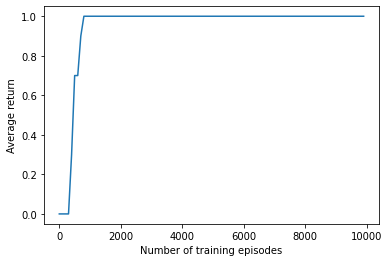

In [ ]:
import matplotlib.pyplot as plt

num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Small_TXT_TEMPLATE)
Na = environment.num_actions()

# Define your DoubleQLearningAgent here
agent = DoubleQLearningAgent(environment, gamma=0.9, alpha=0.03, epsilon=0.15, max_steps=num_episodes)

all_rewards = []
episodes = []

def run_episode(agent: DoubleQLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward
plt.figure(figsize=(15, 7))
print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
  run_episode(agent, environment, max_steps=2000, eval=False)
  agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

##### Showing one trjectory

In [ ]:
run_episode(agent, environment, eval=True, render=True)

Step: 0
#######  #######
#  S  #  #P  GP#
### ###  ##   ##
  # ######## #  
  #          #  
  ############  
Step: 1
#######  #######
#     #  #P  GP#
###S###  ##   ##
  # ######## #  
  #          #  
  ############  
Step: 2
#######  #######
#     #  #P  GP#
### ###  ##   ##
  #S######## #  
  #          #  
  ############  
Step: 3
#######  #######
#     #  #P  GP#
### ###  ##   ##
  # ######## #  
  #S         #  
  ############  
Step: 4
#######  #######
#     #  #P  GP#
### ###  ##   ##
  # ######## #  
  # S        #  
  ############  
Step: 5
#######  #######
#     #  #P  GP#
### ###  ##   ##
  # ######## #  
  #  S       #  
  ############  
Step: 6
#######  #######
#     #  #P  GP#
### ###  ##   ##
  # ######## #  
  #   S      #  
  ############  
Step: 7
#######  #######
#     #  #P  GP#
### ###  ##   ##
  # ######## #  
  #    S     #  
  ############  
Step: 8
#######  #######
#     #  #P  GP#
### ###  ##   ##
  # ######## #  
  #     S    #  
  ############  
Step: 9
##

1.0

#### Large Maze environment

##### Studying the effect of the learning rate $\alpha$

Streaming output truncated to the last 5000 lines.
	100900	|	0.9
	101000	|	0.8
	101100	|	0.9
	101200	|	1.0
	101300	|	0.9
	101400	|	1.0
	101500	|	1.0
	101600	|	1.0
	101700	|	0.8
	101800	|	1.0
	101900	|	0.9
	102000	|	1.0
	102100	|	0.8
	102200	|	0.7
	102300	|	1.0
	102400	|	1.0
	102500	|	0.8
	102600	|	1.0
	102700	|	0.9
	102800	|	0.8
	102900	|	0.9
	103000	|	1.0
	103100	|	0.9
	103200	|	1.0
	103300	|	1.0
	103400	|	1.0
	103500	|	1.0
	103600	|	0.9
	103700	|	1.0
	103800	|	1.0
	103900	|	1.0
	104000	|	0.8
	104100	|	0.9
	104200	|	1.0
	104300	|	1.0
	104400	|	1.0
	104500	|	1.0
	104600	|	1.0
	104700	|	1.0
	104800	|	1.0
	104900	|	1.0
	105000	|	1.0
	105100	|	0.8
	105200	|	0.8
	105300	|	1.0
	105400	|	0.9
	105500	|	1.0
	105600	|	1.0
	105700	|	1.0
	105800	|	1.0
	105900	|	1.0
	106000	|	1.0
	106100	|	1.0
	106200	|	0.9
	106300	|	0.9
	106400	|	0.8
	106500	|	0.9
	106600	|	0.9
	106700	|	0.8
	106800	|	1.0
	106900	|	1.0
	107000	|	1.0
	107100	|	0.8
	107200	|	1.0
	107300	|	0.9
	107400	|	1.0
	107500	|	1.0
	107600	|	1

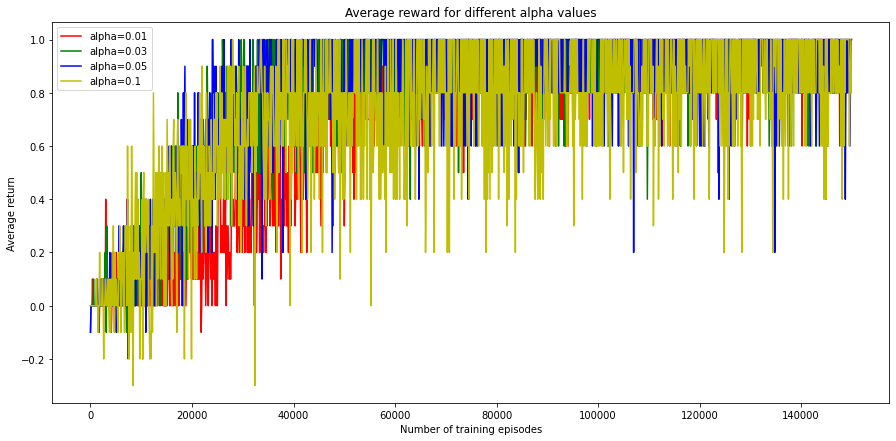

In [ ]:
import matplotlib.pyplot as plt
eps = 0.2 # fixed epsilon value
alphas = [0.01, 0.03, 0.05, 0.1] # range of alpha values to test

num_episodes = 150000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Large_TXT_TEMPLATE)
Na = environment.num_actions()

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward


 

all_rewards = []

plt.figure(figsize=(15, 7))

for alpha, color in zip(alphas, colors):
    agent = DoubleQLearningAgent(environment, gamma=0.9, alpha=alpha, epsilon=eps, max_steps=num_episodes)
    rewards = []
    print(f" alpha = {alpha}")
    print("Episode number:\t| Average reward on 100 eval episodes")
    print("------------------------------------------------------")
    episodes = []
    for episode in range(num_episodes):
        run_episode(agent, environment, max_steps=2000, eval=False)
        agent.decay()

        if episode % eval_every_N == 0:
            reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
            print(f"\t{episode}\t|\t{reward}")
            rewards.append(reward)
            episodes.append(episode)

    plt.plot(episodes,rewards, color=color, label=f'alpha={alpha}')

plt.title('Average reward for different alpha values')
plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.legend()
plt.show()

Streaming output truncated to the last 5000 lines.
	100900	|	0.9
	101000	|	0.9
	101100	|	0.9
	101200	|	0.8
	101300	|	0.8
	101400	|	1.0
	101500	|	1.0
	101600	|	0.8
	101700	|	1.0
	101800	|	1.0
	101900	|	1.0
	102000	|	1.0
	102100	|	0.8
	102200	|	0.8
	102300	|	1.0
	102400	|	0.9
	102500	|	1.0
	102600	|	1.0
	102700	|	1.0
	102800	|	0.9
	102900	|	1.0
	103000	|	0.9
	103100	|	1.0
	103200	|	1.0
	103300	|	1.0
	103400	|	0.9
	103500	|	0.8
	103600	|	1.0
	103700	|	1.0
	103800	|	1.0
	103900	|	0.9
	104000	|	1.0
	104100	|	1.0
	104200	|	1.0
	104300	|	0.8
	104400	|	1.0
	104500	|	0.9
	104600	|	0.9
	104700	|	0.9
	104800	|	1.0
	104900	|	0.9
	105000	|	0.8
	105100	|	0.9
	105200	|	0.9
	105300	|	0.8
	105400	|	0.8
	105500	|	1.0
	105600	|	1.0
	105700	|	1.0
	105800	|	0.8
	105900	|	1.0
	106000	|	0.8
	106100	|	1.0
	106200	|	1.0
	106300	|	1.0
	106400	|	1.0
	106500	|	1.0
	106600	|	1.0
	106700	|	1.0
	106800	|	0.9
	106900	|	0.9
	107000	|	0.8
	107100	|	0.9
	107200	|	1.0
	107300	|	1.0
	107400	|	1.0
	107500	|	0.9
	107600	|	1

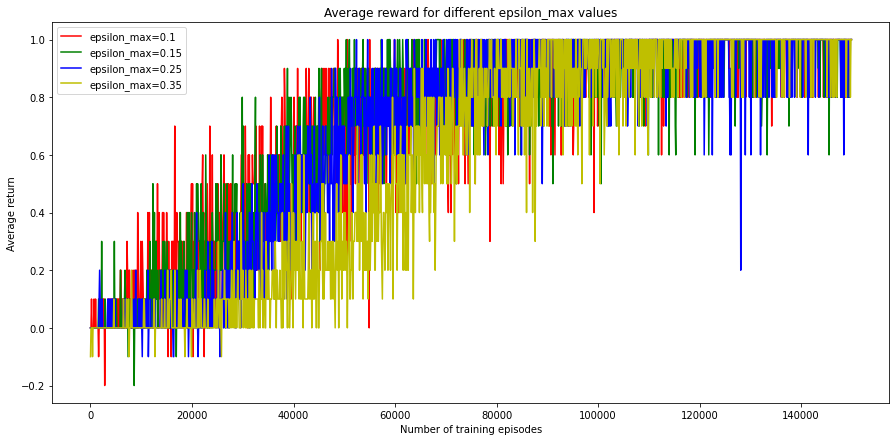

In [ ]:
import matplotlib.pyplot as plt
alpha = 0.01 # fixed alpha value
epsilons = [0.1, 0.15, 0.25,0.35] # range of alpha values to test
colors = ['r', 'g', 'b','y']
num_episodes = 150000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Large_TXT_TEMPLATE)
Na = environment.num_actions()

def run_episode(agent: QLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  # agent.first_observe(state)
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward




all_rewards = []

plt.figure(figsize=(15, 7))

for eps, color in zip(epsilons, colors):
    agent = DoubleQLearningAgent(environment, gamma=0.9, alpha=alpha, epsilon=eps, max_steps=num_episodes)
    rewards = []
    print(f" epsilon_max = {eps}")
    print("Episode number:\t| Average reward on 100 eval episodes")
    print("------------------------------------------------------")
    episodes = []
    for episode in range(num_episodes):
        run_episode(agent, environment, max_steps=2000, eval=False)
        agent.decay()

        if episode % eval_every_N == 0:
            reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
            print(f"\t{episode}\t|\t{reward}")
            rewards.append(reward)
            episodes.append(episode)

    plt.plot(episodes,rewards, color=color, label=f'epsilon_max={eps}')

plt.title('Average reward for different epsilon_max values')
plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.legend()
plt.show()

From these experiments, we can see that Double Q-learning requires more episodes than Q-learning, especially for the large maze environment. This is because it uses two Q-value functions instead of one. This means that during the learning process, the agent needs to update two sets of Q-values, which requires more computations and more episodes to converge to an optimal policy.

Additionally, since the agent is selecting actions based on the sum of the Q-values from both Q-value functions, it may take longer to converge because it needs to balance the exploration of both functions to avoid overestimating the value of actions. In contrast, Q-learning only uses one Q-value function and selects actions based on the maximum Q-value, which may lead to faster convergence.

Furthermore, in the case of our maze environment, since the optimal path changes every episode, the agent needs to explore more to find the optimal path in each episode, and using two Q-value functions may slow down the exploration process. This may result in Double Q-learning requiring more episodes to find the optimal policy compared to Q-learning.

##### Run agent on the Large Maze grid

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.0
	200	|	0.0
	300	|	0.0
	400	|	0.0
	500	|	0.0
	600	|	0.0
	700	|	0.0
	800	|	0.0
	900	|	0.0
	1000	|	0.0
	1100	|	0.0
	1200	|	0.0
	1300	|	0.0
	1400	|	0.1
	1500	|	-0.1
	1600	|	0.0
	1700	|	0.0
	1800	|	0.0
	1900	|	0.0
	2000	|	0.1
	2100	|	0.0
	2200	|	0.0
	2300	|	0.0
	2400	|	0.0
	2500	|	0.0
	2600	|	0.0
	2700	|	0.0
	2800	|	0.1
	2900	|	0.0
	3000	|	0.0
	3100	|	0.0
	3200	|	0.0
	3300	|	0.1
	3400	|	0.0
	3500	|	0.1
	3600	|	0.0
	3700	|	0.0
	3800	|	0.0
	3900	|	0.0
	4000	|	0.0
	4100	|	0.0
	4200	|	0.0
	4300	|	0.0
	4400	|	0.1
	4500	|	0.0
	4600	|	0.0
	4700	|	0.0
	4800	|	0.0
	4900	|	0.2
	5000	|	0.0
	5100	|	0.1
	5200	|	0.0
	5300	|	0.0
	5400	|	0.0
	5500	|	0.0
	5600	|	0.0
	5700	|	0.0
	5800	|	0.1
	5900	|	0.0
	6000	|	0.1
	6100	|	0.1
	6200	|	0.1
	6300	|	0.0
	6400	|	0.0
	6500	|	0.0
	6600	|	0.0
	6700	|	0.0
	6800	|	0.0
	6900	|	0.2
	7000	|	0.2
	7100	|	0.0
	7200	|	0.2
	7300	|	0.0
	7400	|	0.0
	7

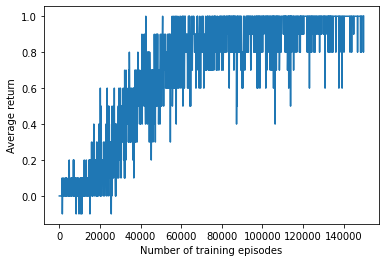

In [ ]:
import matplotlib.pyplot as plt

num_episodes = 150000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Large_TXT_TEMPLATE)
Na = environment.num_actions()

# Define your DoubleQLearningAgent here
agent = DoubleQLearningAgent(environment, gamma=0.9, alpha=0.01, epsilon=0.2, max_steps=num_episodes)

all_rewards = []
episodes = []

def run_episode(agent: DoubleQLearningAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
  # Reset any counts and start the environment.
  state = environment.reset()
  agent.reset_count()
  n_steps = 0

  # Run an episode.
  while True:
    if render:
      print(f'Step: {n_steps}')
      print(environment.render())

    # Generate an action from the agent's policy and step the environment.
    action = agent.act(state, eval=eval)
    next_state, reward, done = environment.step(action)

    if not eval:
      agent.update(state, action, next_state, reward, done)
    n_steps += 1

    state = next_state.copy()
    if done or n_steps > max_steps:
      break

  return reward

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
  run_episode(agent, environment, max_steps=2000, eval=False)
  agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

##### Showing one trajectory

In [ ]:
run_episode(agent, environment, eval=True, render=True)

Step: 0
#########################################
#   #     #P P# #      #         #    PP#
#   #         # #####  #   #     #      #
#   ####  #   # #      #   #            #
#         #   # #      #   ###########  #
###########         #      #            #
#         #             #  ###S       G #
#     #   ##################    #########
#######   #      #P                     #
#                       #       P#      #
#########################################
Step: 1
#########################################
#   #     #P P# #      #         #    PP#
#   #         # #####  #   #     #      #
#   ####  #   # #      #   #            #
#         #   # #      #   ###########  #
###########         #      #            #
#         #             #  ### S      G #
#     #   ##################    #########
#######   #      #P                     #
#                       #       P#      #
#########################################
Step: 2
#########################################
#   #     

1.0

Takeaway : 

In our maze environment, Q-learning performs better than Double Q-learning, which may seem counterintuitive since Double Q-learning is an improvement over Q-learning. The reason for this is that in our maze environment, the state-action pairs are updated infrequently because the environment is sparse, and the agent has to explore a lot to find the goal. In Q-learning, we update the Q-values for all state-action pairs in each episode, while in Double Q-learning, we update the Q-values for only half of the state-action pairs in each episode. This means that the learning process in Double Q-learning is slower than in Q-learning, which requires more episodes to converge. Additionally, since our maze environment is deterministic, the possibility of overestimating the Q-values is low, so Double Q-learning does not provide any significant advantage over Q-learning.

## Other Algorithms we tried

### SARSA agent

The following is an implementation of the `SARSA` algorithm with a `temperature` parameter. SARSA stands for State-Action-Reward-State-Action, which means that the algorithm updates the action-value estimates based on the current state, action, reward, next state and next action. The temperature parameter is used to control the level of exploration vs exploitation during action selection. A higher temperature means that the agent is more likely to choose a suboptimal action, while a lower temperature means that the agent is more likely to choose the optimal action. The agent starts with an initial temperature and gradually decreases it over time until it reaches the end temperature. The algorithm uses a softmax function to calculate the probability of taking each action given the current state and the action-value estimates. The agent also has an alpha parameter for the learning rate, a gamma parameter for the discount factor, and a `q_values` dictionary to store the action-value estimates.

In [13]:
def softmax(x):
  y = np.exp(x)
  return y / y.sum(axis=-1, keepdims=True)

class SARSAAgent:
    def __init__(self, env: Maze, alpha: float, gamma: float, init_temperature:float, end_temperature:float):
        self._env = env
        self._alpha = alpha
        self._gamma = gamma
        self._init_temperature = init_temperature
        self._Na = env.num_actions()
        self._temperature = init_temperature
        self._end_temperature = end_temperature
        self._q_values = {}
        self._step = 0
        self._max_step = 100000
    
    def act(self, state: chex.Array, eval: bool = False) -> int:
        state_key = np_to_hash(state)
        if state_key not in self._q_values:
            self._q_values[state_key] = np.zeros(self._env.num_actions())
            return random_policy(state, self._Na)
        if not eval:
            logits = self._q_values[state_key] / self._temperature
            probabilities = softmax(logits)
            action = np.random.choice(self._Na, p=probabilities)      
        else:
            action = np.argmax(self._q_values[state_key])
        return action
      
    def update(self, state: chex.Array, action: int, next_state: chex.Array, next_action: int, reward: float, done: bool) -> None:
        state_key = np_to_hash(state)
        next_state_key = np_to_hash(next_state)      
        if state_key not in self._q_values:
            self._q_values[state_key] = np.zeros(self._env.num_actions())
        if next_state_key not in self._q_values:
            self._q_values[next_state_key] = np.zeros(self._env.num_actions())
        q_sa = self._q_values[state_key][action]
        q_sprime_aprime = self._q_values[next_state_key][next_action]
        target = reward + self._gamma * q_sprime_aprime * (1 - done) 
        self._q_values[state_key][action] = q_sa + self._alpha * (target - q_sa)

        self._temperature = self._step/self._max_step * self._end_temperature + (1-self._step/self._max_step)*self._init_temperature

    def reset_count(self):
        self._q_values = {}

Episode number:	| Average reward on 100 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.0
	200	|	0.2
	300	|	0.0
	400	|	0.0
	500	|	0.0
	600	|	0.0
	700	|	0.0
	800	|	0.0
	900	|	0.0
	1000	|	0.0
	1100	|	0.3
	1200	|	0.5
	1300	|	0.2
	1400	|	0.0
	1500	|	0.3
	1600	|	0.0
	1700	|	0.3
	1800	|	0.0
	1900	|	0.5
	2000	|	0.0
	2100	|	0.0
	2200	|	0.5
	2300	|	0.0
	2400	|	0.0
	2500	|	0.5
	2600	|	0.2
	2700	|	0.0
	2800	|	0.3
	2900	|	0.8
	3000	|	0.0
	3100	|	0.5
	3200	|	0.1
	3300	|	0.3
	3400	|	0.6
	3500	|	0.5
	3600	|	0.0
	3700	|	0.5
	3800	|	0.0
	3900	|	0.4
	4000	|	0.0
	4100	|	0.2
	4200	|	0.0
	4300	|	0.3
	4400	|	0.3
	4500	|	0.4
	4600	|	0.0
	4700	|	0.3
	4800	|	0.2
	4900	|	0.3
	5000	|	0.4
	5100	|	0.1
	5200	|	0.0
	5300	|	0.0
	5400	|	0.3
	5500	|	0.1
	5600	|	0.5
	5700	|	0.5
	5800	|	0.0
	5900	|	0.0
	6000	|	0.0
	6100	|	0.0
	6200	|	0.0
	6300	|	0.0
	6400	|	0.0
	6500	|	0.0
	6600	|	0.0
	6700	|	0.0
	6800	|	0.0
	6900	|	0.0
	7000	|	0.0
	7100	|	0.0
	7200	|	0.4
	7300	|	0.0
	7400	|	0.2
	75

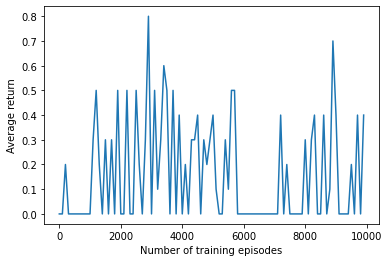

In [15]:
# Run SARSA agent
import matplotlib.pyplot as plt

num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Small_TXT_TEMPLATE)

alpha = 0.08
gamma = 0.9
init_temperature = 35
end_temperature = 1
agent = SARSAAgent(environment, alpha, gamma, init_temperature, end_temperature)
all_rewards = []
episodes = []

def run_episode(agent: SARSAAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
    # Reset any counts and start the environment.
    state = environment.reset()
    #agent.reset_count()
    n_steps = 0

    # Run an episode.
    while True:
        if render:
            print(f'Step: {n_steps}')
            print(environment.render())

        # Generate an action from the agent's policy and step the environment.
        action = agent.act(state, eval=eval)
        next_state, reward, done = environment.step(action)

        if not eval:
            next_action = agent.act(next_state)
            agent.update(state, action, next_state, next_action, reward, done)

        n_steps += 1
        state = next_state.copy()

        if done or n_steps > max_steps:
            break

    return reward

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
    run_episode(agent, environment, max_steps=2000, eval=False)
    
    if episode % eval_every_N == 0:
        reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
        print(f"\t{episode}\t|\t{reward}")
        all_rewards.append(reward)
        episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)
plt.show()

In [20]:
run_episode(agent, environment, eval=True, render=True)

Step: 0
#######  #######
#  S  #  #  G P#
### ###  ##P  ##
  # ######## #  
  #          #  
  ############  
Step: 1
#######  #######
#     #  #  G P#
###S###  ##P  ##
  # ######## #  
  #          #  
  ############  
Step: 2
#######  #######
#     #  #  G P#
### ###  ##P  ##
  #S######## #  
  #          #  
  ############  
Step: 3
#######  #######
#     #  #  G P#
### ###  ##P  ##
  # ######## #  
  #S         #  
  ############  
Step: 4
#######  #######
#     #  #  G P#
### ###  ##P  ##
  # ######## #  
  # S        #  
  ############  
Step: 5
#######  #######
#     #  #  G P#
### ###  ##P  ##
  # ######## #  
  #  S       #  
  ############  
Step: 6
#######  #######
#     #  #  G P#
### ###  ##P  ##
  # ######## #  
  #   S      #  
  ############  
Step: 7
#######  #######
#     #  #  G P#
### ###  ##P  ##
  # ######## #  
  #    S     #  
  ############  
Step: 8
#######  #######
#     #  #  G P#
### ###  ##P  ##
  # ######## #  
  #     S    #  
  ############  
Step: 9
##

1.0

### SARSA + epsilon-greedy policy 

The second SARSA agent uses different exploration strategy compared to the standard SARSA agent. Instead of using a softmax policy with a temperature parameter, it uses an epsilon-greedy policy with an action noise term. The action noise term is designed to encourage exploration, similar to the temperature parameter in the softmax policy. It scales with the magnitude of the Q-values, which may help to control exploration as the Q-values change during learning. Overall, this exploration strategy could work well depending on the specific problem and learning dynamics.

In [ ]:
def softmax(x):
  y = np.exp(x)
  return y / y.sum(axis=-1, keepdims=True)

class ModifiedSARSAAgent:
    def __init__(self, env: Maze, alpha: float, gamma: float):
        self._env = env
        self._alpha = alpha
        self._gamma = gamma
        self._q_values = {}
        self._Na = env.num_actions()

    def act(self, state: chex.Array, eval: bool = False) -> int:
        state_key = np_to_hash(state)
        if state_key not in self._q_values:
            self._q_values[state_key] = np.zeros(self._env.num_actions())
            return random_policy(state, self._Na)
        if not eval:
            q_values = self._q_values[state_key]
            action_eps = np.random.randn() / np.sqrt(sum(q_values ** 2) + 1)
            action = np.argmax(q_values + action_eps)
            return action
        return np.argmax(self._q_values[state_key])

    def update(self, state: chex.Array, action: int, next_state: chex.Array, next_action: int, reward: float, done: bool) -> None:
        state_key = np_to_hash(state)
        next_state_key = np_to_hash(next_state)
        if state_key not in self._q_values:
            self._q_values[state_key] = np.zeros(self._env.num_actions())
        if next_state_key not in self._q_values:
            self._q_values[next_state_key] = np.zeros(self._env.num_actions())
        q_sa = self._q_values[state_key][action]
        q_sprime_aprime = self._q_values[next_state_key][next_action]
        target = reward + self._gamma * q_sprime_aprime * (1 - done)
        self._q_values[state_key][action] = q_sa + self._alpha * (target - q_sa)

    def reset_count(self):
        self._count_values = {}


In [ ]:
# Run SARSA agent
import matplotlib.pyplot as plt

num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Small_TXT_TEMPLATE)

agent = ModifiedSARSAAgent(environment, alpha=0.1, gamma=0.9)
all_rewards = []
episodes = []

def run_episode(agent: ModifiedSARSAAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
    # Reset any counts and start the environment.
    state = environment.reset()
    n_steps = 0

    # Run an episode.
    while True:
        if render:
            print(f'Step: {n_steps}')
            print(environment.render())

        # Generate an action from the agent's policy and step the environment.
        action = agent.act(state, eval=eval)
        next_state, reward, done = environment.step(action)

        if not eval:
            next_action = agent.act(next_state)
            agent.update(state, action, next_state, next_action, reward, done)

        n_steps += 1
        state = next_state.copy()

        if done or n_steps > max_steps:
            break

    return reward

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
    run_episode(agent, environment, max_steps=2000, eval=False)
    
    if episode % eval_every_N == 0:
        reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
        print(f"\t{episode}\t|\t{reward}")
        all_rewards.append(reward)
        episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)
plt.show()

### Why doesn't these agent lean an optimal policy?


SARSA agent might not work well for this Maze setting due to its on-policy nature. Since the maze environment is complex and has many obstacles, it might be difficult for the agent to learn an optimal policy while taking actions according to the current policy. This is because the agent may get stuck in local optima and never explore alternative paths that could lead to the optimal solution.

In other words, SARSA agent might not explore enough to find the optimal path since it's following a policy that might not be optimal. On the other hand, Q-learning agent can explore more and find the optimal path since it follows a greedy policy with respect to the current action-value function, which allows it to take non-greedy actions and explore different paths.

### Dyna-Q Agent

The following is an implementation of the Dyna-Q algorithm, which is an extension of the Q-learning algorithm that uses a model of the environment to plan and update the Q-values. The main difference between Q-learning and Dyna-Q is that Dyna-Q performs a number of simulated planning steps after each real experience to update the Q-values based on the model, which allows the agent to explore and learn more efficiently.

A breakdown of the implementation:

- The constructor initializes the `environment`, the learning rate (`alpha`), the discount factor (`gamma`), the exploration rate (`epsilon`), the number of planning steps (`planning_steps`), the maximum number of steps (`max_steps`), the action-value function (`q_values`), the model of the environment (`model`), and the count of state-action pairs visited (`count_values`).

- The act method takes a state as input and returns an action. It selects an action based on an epsilon-greedy policy, where with probability epsilon, the agent chooses a random action, and with probability 1-epsilon, it chooses the action with the highest Q-value for the current state.

- The update method updates the Q-values based on the real experience (state, action, next_state, reward, done) and performs planning steps based on the model. It first updates the count of state-action pairs visited, and then adjusts the reward based on how many times this pair has been visited before. It then updates the Q-value for the current state-action pair using the Q-learning update rule. It also updates the model with the observed experience. Finally, it performs a number of planning steps by randomly selecting a state-action pair from the model and updating the Q-value for that pair based on the simulated experience from the model.

- reset_count and decay methods are as described earlier.

In [ ]:
class DynaQAgent:
  def __init__(self, env: Maze, alpha: float, gamma: float, epsilon: float, planning_steps: int, max_steps: int):
    self._env = env
    self._alpha = alpha
    self._gamma = gamma
    self._epsilon = epsilon
    self._Na = env.num_actions()
    self._q_values = {}
    self._planning_steps = planning_steps
    self._max_steps = max_steps
    self._model = {}
    self._count_values = {}

  def act(self, state: chex.Array, eval: bool = False) -> int:
    state_key = np_to_hash(state)
    if not eval and np.random.rand() < self._epsilon:
      return random_policy(state, self._Na)
    if state_key not in self._q_values:
      return random_policy(state, self._Na)
    return np.argmax(self._q_values[state_key])

  def update(self, state: chex.Array, action: int, next_state: chex.Array, reward: float, done: bool) -> None:
    state_key = np_to_hash(state)
    next_state_key = np_to_hash(next_state)
    if state_key not in self._count_values:
      self._count_values[state_key] = np.zeros(self._env.num_actions())
    reward -= self._count_values[state_key][action] / (self._count_values[state_key][action] + 4)
    self._count_values[state_key][action] += 1

    if state_key not in self._q_values:
      self._q_values[state_key] = np.zeros(self._env.num_actions())
    if next_state_key not in self._q_values:
      self._q_values[next_state_key] = np.zeros(self._env.num_actions())
    self._q_values[state_key][action] = (1 - self._alpha) * self._q_values[state_key][action] \
                                        + self._alpha * (
                                                reward + self._gamma * np.max(self._q_values[next_state_key]) * (
                                                1 - done))

    if state_key not in self._model:
      self._model[state_key] = {}
    self._model[state_key][action] = (next_state, reward, done)

    for _ in range(self._planning_steps):
      state_key_planning = list(self._model.keys())[np.random.randint(len(self._model))]
      action_planning = np.random.randint(self._env.num_actions())
      next_state_planning, reward_planning, done_planning = self._model[state_key_planning][action_planning]
      next_state_key_planning = np_to_hash(next_state_planning)
      if state_key_planning not in self._q_values:
        self._q_values[state_key_planning] = np.zeros(self._env.num_actions())
      if next_state_key_planning not in self._q_values:
        self._q_values[next_state_key_planning] = np.zeros(self._env.num_actions())
      self._q_values[state_key_planning][action_planning] = (1 - self._alpha) * self._q_values[state_key_planning][
        action_planning] + self._alpha * (
                                                                    reward_planning + self._gamma * np.max(
                                                                  self._q_values[next_state_key_planning]) * (
                                                                            1 - done_planning))

  def reset_count(self):
    self._count_values = {}

  def decay(self):
    self._epsilon -= (self._epsilon - 0.01) / self._max_steps

In [ ]:
import matplotlib.pyplot as plt

num_episodes = 10000
num_eval_episodes = 10
eval_every_N = 100

environment = Maze(Small_TXT_TEMPLATE)
Na = environment.num_actions()

# Define your DynaQAgent here
agent = DynaQAgent(environment, gamma=0.9, alpha=0.03, epsilon=0.15, planning_steps=5, max_steps=num_episodes)
all_rewards = []
episodes = []

def run_episode(agent: DynaQAgent, env: Maze, eval: bool, max_steps: int = 2000, render: bool = False) -> float:
    # Reset any counts and start the environment.
    state = environment.reset()
    # agent.first_observe(state)
    agent.reset_count()
    n_steps = 0

    # Run an episode.
    while True:
        if render:
            print(f'Step: {n_steps}')
            print(environment.render())

        # Generate an action from the agent's policy and step the environment.
        action = agent.act(state, eval=eval)
        next_state, reward, done = environment.step(action)

        if not eval:
            agent.update(state, action, next_state, reward, done)
        n_steps += 1

        state = next_state.copy()
        if done or n_steps > max_steps:
            break

    return reward

print("Episode number:\t| Average reward on 100 eval episodes")
print("------------------------------------------------------")

for episode in range(num_episodes):
    run_episode(agent, environment, max_steps=2000, eval=False)
    agent.decay()

    if episode % eval_every_N == 0:
        reward = np.mean([run_episode(agent, environment, eval=True, render=False) for _ in range(num_eval_episodes)])
        print(f"\t{episode}\t|\t{reward}")
        all_rewards.append(reward)
        episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

### Why doesn't these agent lean an optimal policy?

The fact that the position of the goal and pits change every episode is likely a major factor in the poor performance of the DynaQ agent. Since the agent's planning is based on its previous experience, and the environment changes in every episode, the agent's previous experience may not be relevant or useful for the current episode. As a result, the agent may struggle to learn an optimal policy or to plan effectively.

In addition, the exploration-exploitation tradeoff can be particularly challenging in environments where the goal and obstacles change in each episode. The agent may need to spend more time exploring new parts of the environment to find the new goal and avoid the new obstacles, which can make it harder to converge to an optimal policy.

# **[Exercice 2]** Implementing a deep RL Algorithm.

Your second (harder) task is to implement a _Deep RL algorithm_ for the maze environment. You can go for either DQN or a variant of policy gradient of your choice. Again, feel free to take inspiration from the other practicals.

## Agent API
Your agent must implement the following functions:
- `def act(self, state: chex.Array, eval: bool = False) -> int` a function that takes in an observation and returns the action selected by the agent. `eval=True` means that you should use the learnt policy, `eval=False` means that you should use the acting policy. Depending on your choice of agent, these two policies may or may not differ.
- ` def first_observe(self, state: chex.Array) -> None:` a function that takes care of handling the first observation obtained after a reset. This function can notably memorize the first state, so that when we call observe, we have a full transition `(state, action, reward, done, next_state)` at our disposal.
- `def observe(self, action_t: chex.Array, reward_t: chex.Array, done_t: chex.Array, state_tp1: chex.Array) -> chex.Array:` a function that takes an action, a reward, a termination signal and a next state, and performs any update required by our agent to update its policy. To make things much easier, you should look at what this function is doing for the implementation in the DQN practical.

# DQN

In [ ]:
#@title Catch Network { form-width: "30%" }

# To convert bool to float
def ProcessState(state: chex.Array):
  return state.astype(float)

def np_to_hash(state: chex.Array) -> Tuple[int, int, Tuple[int, int], Tuple[Tuple[int, int], ...]]:
    n_rows, n_cols, n_channels = state.shape

    # Find player location
    player_pos = np.where(state[..., 1] == 1)
    player_pos = (player_pos[0][0], player_pos[1][0])

    # Find goal location
    goal_pos = np.where(state[..., 2] == 1)
    if goal_pos[0].size == 0:
        # No goal found, so return player position for both
        goal_pos = player_pos
    else:
        goal_pos = (goal_pos[0][0], goal_pos[1][0])
    
    return player_pos, goal_pos

def catch_network(x: chex.Array, env, state_dim):
  out = hk.Flatten()(x[...,[1,2]])
  out = jax.nn.relu(hk.Linear(state_dim)(out))
  out = jax.nn.softmax(hk.Linear(env.num_actions())(out), axis=-1)
  return out

In [ ]:
#@title Replaybuffer

import dataclasses
@chex.dataclass
class Transition:
  state_t: chex.Array
  action_t: chex.Array
  reward_t: chex.Array
  done_t: chex.Array
  state_tp1: chex.Array

class ReplayBuffer:
  """Fixed-size buffer to store transition tuples."""

  def __init__(self, buffer_capacity: int):
      """Initialize a ReplayBuffer object.
      Args:
          buffer_capacity (int): maximal number of tuples to store at once
      """
      self._memory = list()
      self._maxlen = buffer_capacity

  @property
  def size(self) -> int:
    # Return the current number of elements in the buffer.
    return len(self._memory)

  def add(self, state_t: chex.Array,
          action_t: chex.Array,
          reward_t: chex.Array,
          done_t: chex.Array,
          state_tp1: chex.Array) -> None:
      """Add a new transition to memory."""
      
      if self.size > self._maxlen:
        self._memory = self._memory[1:]

      self._memory.append(Transition(state_t=state_t,
                        action_t=action_t,
                        reward_t=reward_t,
                        done_t=done_t,
                        state_tp1=state_tp1,))

  def sample(self) -> Transition:
      """Randomly sample a transition from memory."""
      assert self._memory, 'replay buffer is unfilled'
      index = np.random.randint(self.size)
      return self._memory[index]

class BatchedReplayBuffer(ReplayBuffer):

  def sample_batch(self, batch_size) -> Transition:
    """Randomly sample a batch of experiences from memory."""
    assert len(self._memory) >= batch_size, 'Insuficient number of transitions in replay buffer'
    # Your code here !
    samples = [self.sample() for i in range(batch_size)]
    kwargs = dict()
    for attr in ["state_t", "action_t", "reward_t", "done_t", "state_tp1"]:
        kwargs[attr] = np.array([getattr(s, attr) for s in samples])
    return Transition(**kwargs)


In [ ]:
# @title DeepAgent
@chex.dataclass
class LearnerState:
  online_params: hk.Params
  target_params: hk.Params
  opt_state: optax.OptState
  

class DeepAgent:
  def __init__(self, env, gamma, lr, eps, target_ema, buffer_capacity, min_buffer_capacity, 
               batch_size, state_dim, min_epsilon = 0.1, max_steps = 5000, reward_shaping = True, sampling = "epsilon"):
    self._state = None
    self._gamma = gamma
    self._lr = lr
    self._env = env
    self._eps = eps
    self._max_epsilon = eps
    self._min_epsilon = min_epsilon
    self._step = 0
    self._max_steps = max_steps
    self._state_dim = state_dim
    self._sampling = sampling

    self._Na = env.num_actions()
    self._target_ema = target_ema
    self._batch_size = batch_size
    self._min_buffer_capacity = min_buffer_capacity
    self._reward_shaping = reward_shaping

    self._init, self._apply = hk.without_apply_rng(hk.transform(self._hk_qfunction))
    self.apply = jax.jit(self._apply)

    self._rng = jax.random.PRNGKey(0)
    self._rng, init_rng = jax.random.split(self._rng)
    self._learner_state = self._init_state(init_rng)

    self._update_fn = jax.jit(self.update_fn)
    self._buffer = BatchedReplayBuffer(buffer_capacity)
    self._state = None

    self._counting_values = {}
    self._num_updates = 0
    self._step_in_an_episode = 0
  
  def first_observe(self, state:chex.Array):
    self._state = state

  def _hk_qfunction(self, state:chex.Array):
    return catch_network(state, self._env, self._state_dim)

  def _optimizer(self):
    return optax.adam(learning_rate = self._lr)
  
  def _init_state(self, rng)->LearnerState:
    state = self._env.reset()
    bstate = ProcessState(state[None])
    online_params = self._init(rng, bstate)
    target_params = self._init(rng, bstate)
    opt_state = self._optimizer().init(online_params)
    return LearnerState(online_params = online_params, target_params = target_params, opt_state = opt_state)
  
  def random_policy(self):
    return np.random.randint(self._Na)

  def Thompson_sample(self, qvalue):
    variance = np.var(qvalue)
    samples = np.random.normal(qvalue, variance)
    return np.argmax(samples)

  def act(self, state:chex.Array, eval:bool):
    bstate = ProcessState(state[None]) 
    if eval:
      logits = self.apply(self._learner_state.online_params, bstate)
      return jnp.argmax(logits)
    else:
      # random search at the first few episodes
      if self._step_in_an_episode < 50 and self._step < 100:
        self._step_in_an_episode += 1
        return self.random_policy()

      logits = self.apply(self._learner_state.online_params, bstate)
      if self._sampling == "epsilon":
        if np.random.rand()<self._eps:
          action = self.random_policy()
        else:
          action = jnp.argmax(logits)
      elif self._sampling == "Thompson":
        action = self.Thompson_sample(logits)
      return action
  
  def loss_fn(self,
      online_params: hk.Params,
      target_params: hk.Params,
      state_t: chex.Array,
      action_t: chex.Array,
      reward_t: chex.Array,
      done_t: chex.Array,
      state_tp1: chex.Array,
      ) -> chex.Array:
    q_t = self.apply(online_params, state_t)
    q_values = jax.vmap(lambda idx, q : q[idx])(action_t, q_t)
    y = reward_t + self._gamma * jnp.max(self.apply(target_params, state_tp1) * (1-done_t[..., None]), axis=1) 
    loss = jnp.mean(jnp.square(q_values - y))
    return loss

  def update_fn(self, state: LearnerState, batch: Transition,):
    loss, grad = jax.value_and_grad(self.loss_fn)(state.online_params, state.target_params, batch.state_t, batch.action_t, batch.reward_t, batch.done_t, batch.state_tp1)
    updates, new_opt_state = self._optimizer().update(grad, state.opt_state)

    new_online_params = optax.apply_updates(state.online_params, updates)
    new_target_params = tree_util.tree_map(lambda tg, ol: self._target_ema * tg + (1-self._target_ema) * ol, state.target_params, new_online_params)
    next_state = LearnerState(online_params=new_online_params, target_params=new_target_params, opt_state=new_opt_state)

    return loss, next_state
  
  def observe(self,
              action_t: chex.Array,
              reward_t: chex.Array,
              done_t: chex.Array,
              state_tp1: chex.Array,
              ) -> chex.Array:
    # reward shaping
    if self._reward_shaping:
      if reward_t > 0:
        reward_t *= 5
      state_key = np_to_hash(self._state)
      state_tpl_key = np_to_hash(state_tp1)
      if jnp.all(state_key == state_tpl_key):
        reward_t -= 1
      if state_key not in self._counting_values:
        self._counting_values[state_key] = np.zeros(self._env.num_actions())
      reward_t += 0.2 - self._counting_values[state_key][action_t]/(self._counting_values[state_key][action_t] + 1)
      self._counting_values[state_key][action_t] += 1

    self._buffer.add(ProcessState(self._state), action_t, reward_t, done_t, ProcessState(state_tp1))
    self._state = state_tp1
    if self._buffer.size >= self._min_buffer_capacity:
      batch = self._buffer.sample_batch(self._batch_size)
      loss, self._learner_state = self._update_fn(self._learner_state, batch)
      self._num_updates += 1
      return loss
    return 0.

  def decay(self):
    self._step += 1 
    if self._step < self._max_steps:
      self._eps = self._max_epsilon - self._step * (self._max_epsilon - self._min_epsilon)/self._max_steps

  def reset(self):
    self._counting_values = {}
    self._step_in_an_episode = 0

96


/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Episode number:	| Average reward on 10 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.6
	200	|	1.0
	300	|	1.0
	400	|	1.0
	500	|	1.0
	600	|	1.0
	700	|	1.0
	800	|	1.0
	900	|	1.0
	1000	|	1.0
	1100	|	1.0
	1200	|	1.0
	1300	|	1.0
	1400	|	1.0
	1500	|	1.0
	1600	|	1.0
	1700	|	1.0
	1800	|	1.0
	1900	|	1.0


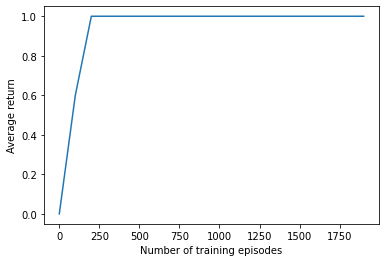

In [ ]:
#@title Run DQN Algorithm(small environment) { form-width: "30%" }

num_episodes = 2000
num_eval_episodes = 10
eval_every_N = 100

env = Maze(Small_TXT_TEMPLATE)
state = env.reset()
h, w, c = state.shape
print(h*w)


deep_agent = DeepAgent(
    env=env,
    gamma=1.0,
    eps=0.2,
    lr=1e-4,
    buffer_capacity=h*w*10,
    min_buffer_capacity=64,
    batch_size=64,
    target_ema=.9,
    state_dim = h*w,
    max_steps = num_episodes
) 

def run_dqn_episode(deep_agent: DeepAgent, env: Maze, eval: bool, max_steps: int = h*w, render = False) -> float:
  # Reset any counts and start the environment.
  state = env.reset().copy()
  deep_agent.first_observe(state)
  num_steps = 0

  deep_agent.reset()

  # Run an episode.
  while True:
    # Generate an action from the agent's policy and step the environment.
    action = deep_agent.act(state, eval)
    next_state, reward, done = env.step(action)
    if not eval:
      deep_agent.observe(action, reward, done, next_state.copy())
    num_steps += 1
    state = next_state.copy()

    if render:
      print(env.render())
    if done or num_steps > max_steps:
      break

  return reward


print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")

episodes = []
all_rewards = []
for episode in range(num_episodes):
  run_dqn_episode(deep_agent, env, eval=False, max_steps = h*w+50)
  deep_agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_dqn_episode(deep_agent, env, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

451


/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Episode number:	| Average reward on 10 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.1
	200	|	0.0
	300	|	0.2
	400	|	0.6
	500	|	0.6
	600	|	0.4
	700	|	0.3
	800	|	0.5
	900	|	0.3
	1000	|	0.3
	1100	|	0.7
	1200	|	0.7
	1300	|	0.4
	1400	|	0.4
	1500	|	0.3
	1600	|	0.1
	1700	|	0.4
	1800	|	0.3
	1900	|	0.2
	2000	|	0.3
	2100	|	0.7
	2200	|	0.4
	2300	|	0.4
	2400	|	0.4
	2500	|	0.7
	2600	|	0.5
	2700	|	0.6
	2800	|	0.5
	2900	|	0.3


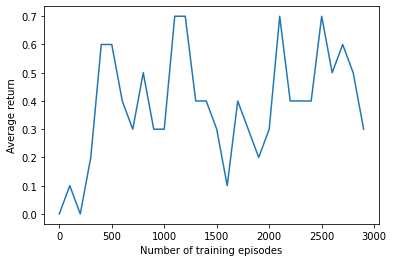

In [ ]:
#@title Run DQN Algorithm(large environment) { form-width: "30%" }

num_episodes = 3000
num_eval_episodes = 10
eval_every_N = 100

env = Maze(Large_TXT_TEMPLATE)
state = env.reset()
h, w, c = state.shape
print(h*w)

deep_agent = DeepAgent(
    env=env,
    gamma=1.0,
    eps=0.2,
    lr=1e-4,
    buffer_capacity=h*w*10,
    min_buffer_capacity=64,
    batch_size=64,
    target_ema=.9,
    state_dim = h*w,
    max_steps = num_episodes
) 

def run_dqn_episode(deep_agent: DeepAgent, env: Maze, eval: bool, max_steps: int = h*w, render = False) -> float:
  # Reset any counts and start the environment.
  state = env.reset().copy()
  deep_agent.first_observe(state)
  num_steps = 0

  deep_agent.reset()

  # Run an episode.
  while True:
    # Generate an action from the agent's policy and step the environment.
    action = deep_agent.act(state, eval)
    next_state, reward, done = env.step(action)
    if not eval:
      deep_agent.observe(action, reward, done, next_state.copy())
    num_steps += 1
    state = next_state.copy()

    if render:
      print(env.render())
    if done or num_steps > max_steps:
      break

  return reward


print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")

episodes = []
all_rewards = []
for episode in range(num_episodes):
  run_dqn_episode(deep_agent, env, eval=False, max_steps = h*w+50)
  deep_agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_dqn_episode(deep_agent, env, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

96
Episode number:	| Average reward on 10 eval episodes
------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


	0	|	0.0
	100	|	0.0
	200	|	1.0
	300	|	1.0
	400	|	1.0
	500	|	1.0
	600	|	1.0
	700	|	1.0
	800	|	1.0
	900	|	1.0
	1000	|	1.0
	1100	|	1.0
	1200	|	1.0
	1300	|	1.0
	1400	|	1.0
	1500	|	1.0
	1600	|	1.0
	1700	|	1.0
	1800	|	1.0
	1900	|	1.0


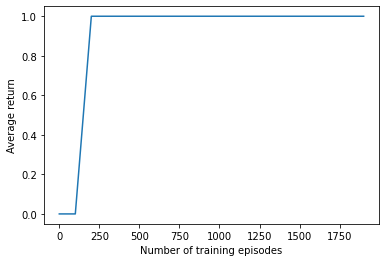

In [ ]:
#@title Effect of reward shaping(small env){ form-width: "30%" }


num_episodes = 2000
num_eval_episodes = 10
eval_every_N = 100

env = Maze(Small_TXT_TEMPLATE)
state = env.reset()
h, w, c = state.shape
print(h*w)


deep_agent = DeepAgent(
    env=env,
    gamma=1.0,
    eps=0.2,
    lr=1e-4,
    buffer_capacity=h*w*10,
    min_buffer_capacity=64,
    batch_size=64,
    target_ema=.9,
    state_dim = h*w,
    max_steps = num_episodes,
    reward_shaping = False
) 

def run_dqn_episode(deep_agent: DeepAgent, env: Maze, eval: bool, max_steps: int = h*w, render = False) -> float:
  # Reset any counts and start the environment.
  state = env.reset().copy()
  deep_agent.first_observe(state)
  num_steps = 0

  deep_agent.reset()

  # Run an episode.
  while True:
    # Generate an action from the agent's policy and step the environment.
    action = deep_agent.act(state, eval)
    next_state, reward, done = env.step(action)
    if not eval:
      deep_agent.observe(action, reward, done, next_state.copy())
    num_steps += 1
    state = next_state.copy()

    if render:
      print(env.render())
    if done or num_steps > max_steps:
      break

  return reward


print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")

episodes = []
all_rewards = []
for episode in range(num_episodes):
  run_dqn_episode(deep_agent, env, eval=False, max_steps = h*w+50)
  deep_agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_dqn_episode(deep_agent, env, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

451
Episode number:	| Average reward on 10 eval episodes
------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


	0	|	0.0
	100	|	-0.1
	200	|	0.0
	300	|	0.0
	400	|	0.0
	500	|	0.2
	600	|	0.0
	700	|	0.1
	800	|	0.1
	900	|	0.1


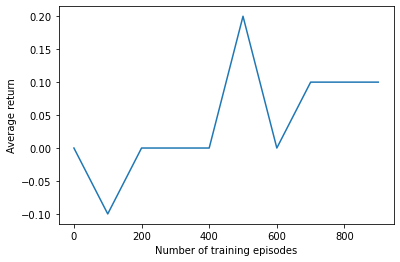

In [ ]:
#@title Effect of reward shaping(large env){ form-width: "30%" }

num_episodes = 1000
num_eval_episodes = 10
eval_every_N = 100

env = Maze(Large_TXT_TEMPLATE)
state = env.reset()
h, w, c = state.shape
print(h*w)

deep_agent = DeepAgent(
    env=env,
    gamma=1.0,
    eps=0.2,
    lr=1e-4,
    buffer_capacity=h*w*10,
    min_buffer_capacity=64,
    batch_size=64,
    target_ema=.9,
    state_dim = h*w,
    max_steps = num_episodes,
    reward_shaping = False
) 

def run_dqn_episode(deep_agent: DeepAgent, env: Maze, eval: bool, max_steps: int = h*w, render = False) -> float:
  # Reset any counts and start the environment.
  state = env.reset().copy()
  deep_agent.first_observe(state)
  num_steps = 0

  deep_agent.reset()

  # Run an episode.
  while True:
    # Generate an action from the agent's policy and step the environment.
    action = deep_agent.act(state, eval)
    next_state, reward, done = env.step(action)
    if not eval:
      deep_agent.observe(action, reward, done, next_state.copy())
    num_steps += 1
    state = next_state.copy()

    if render:
      print(env.render())
    if done or num_steps > max_steps:
      break

  return reward


print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")

episodes = []
all_rewards = []
for episode in range(num_episodes):
  run_dqn_episode(deep_agent, env, eval=False, max_steps = h*w+50)
  deep_agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_dqn_episode(deep_agent, env, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

96
Episode number:	| Average reward on 10 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.0
	200	|	0.6
	300	|	1.0
	400	|	1.0
	500	|	1.0
	600	|	1.0
	700	|	1.0
	800	|	1.0
	900	|	1.0
	1000	|	1.0
	1100	|	1.0
	1200	|	1.0
	1300	|	1.0
	1400	|	1.0
	1500	|	1.0
	1600	|	1.0
	1700	|	1.0
	1800	|	1.0
	1900	|	1.0


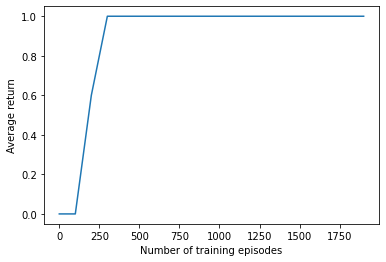

In [ ]:
#@title Study of Thompson sampling(small env){ form-width: "30%" }

num_episodes = 2000
num_eval_episodes = 10
eval_every_N = 100

env = Maze(Small_TXT_TEMPLATE)
state = env.reset()
h, w, c = state.shape
print(h*w)

deep_agent = DeepAgent(
    env=env,
    gamma=1.0,
    eps=0.2,
    lr=1e-4,
    buffer_capacity=h*w*10,
    min_buffer_capacity=64,
    batch_size=64,
    target_ema=.9,
    state_dim = h*w,
    max_steps = num_episodes,
    reward_shaping = True,
    sampling = "Thompson"

) 

def run_dqn_episode(deep_agent: DeepAgent, env: Maze, eval: bool, max_steps: int = h*w, render = False) -> float:
  # Reset any counts and start the environment.
  state = env.reset().copy()
  deep_agent.first_observe(state)
  num_steps = 0

  deep_agent.reset()

  # Run an episode.
  while True:
    # Generate an action from the agent's policy and step the environment.
    action = deep_agent.act(state, eval)
    next_state, reward, done = env.step(action)
    if not eval:
      deep_agent.observe(action, reward, done, next_state.copy())
    num_steps += 1
    state = next_state.copy()

    if render:
      print(env.render())
    if done or num_steps > max_steps:
      break

  return reward


print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")

episodes = []
all_rewards = []
for episode in range(num_episodes):
  run_dqn_episode(deep_agent, env, eval=False, max_steps = h*w+50)
  deep_agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_dqn_episode(deep_agent, env, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

451
Episode number:	| Average reward on 10 eval episodes
------------------------------------------------------
	0	|	0.0
	100	|	0.0
	200	|	0.6
	300	|	0.1
	400	|	0.5
	500	|	-0.1
	600	|	0.3
	700	|	0.7
	800	|	0.1
	900	|	0.1
	1000	|	0.3
	1100	|	0.3
	1200	|	0.4
	1300	|	0.3
	1400	|	0.2


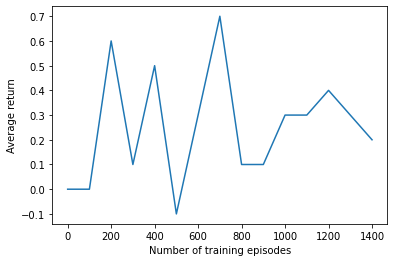

In [ ]:
#@title Study of Thompson sampling(large env){ form-width: "30%" }

num_episodes = 1500
num_eval_episodes = 10
eval_every_N = 100

env = Maze(Large_TXT_TEMPLATE)
state = env.reset()
h, w, c = state.shape
print(h*w)

deep_agent = DeepAgent(
    env=env,
    gamma=1.0,
    eps=0.2,
    lr=1e-4,
    buffer_capacity=h*w*10,
    min_buffer_capacity=64,
    batch_size=64,
    target_ema=.9,
    state_dim = h*w,
    max_steps = num_episodes,
    reward_shaping = True,
    sampling = "Thompson"

) 

def run_dqn_episode(deep_agent: DeepAgent, env: Maze, eval: bool, max_steps: int = h*w, render = False) -> float:
  # Reset any counts and start the environment.
  state = env.reset().copy()
  deep_agent.first_observe(state)
  num_steps = 0

  deep_agent.reset()

  # Run an episode.
  while True:
    # Generate an action from the agent's policy and step the environment.
    action = deep_agent.act(state, eval)
    next_state, reward, done = env.step(action)
    if not eval:
      deep_agent.observe(action, reward, done, next_state.copy())
    num_steps += 1
    state = next_state.copy()

    if render:
      print(env.render())
    if done or num_steps > max_steps:
      break

  return reward


print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")

episodes = []
all_rewards = []
for episode in range(num_episodes):
  run_dqn_episode(deep_agent, env, eval=False, max_steps = h*w+50)
  deep_agent.decay()

  if episode % eval_every_N == 0:
    reward = np.mean([run_dqn_episode(deep_agent, env, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

#Reinforce(failure)

In [ ]:
#@title Catch Policy Network { form-width: "30%" }
def policy_network(x: chex.Array, env) -> chex.Array:
  out = hk.Flatten()(x[...,[1,2]])
  out = jax.nn.relu(hk.Linear(128)(out))
  out = hk.Linear(env.num_actions())(out)
  return jax.nn.softmax(out, axis=-1)

In [ ]:
#@title Cumulative returns { form-width: "30%" }
def cumulative_returns(rewards: chex.Array,
                       dones: chex.Array,
                       gamma: float,
                       ) -> chex.Array:
  Cs = [0.]
  discard = 1
  for n in range(len(rewards)-1, -1, -1):
    discard *= (1-dones[n]) 
    Cs.append((rewards[n] + gamma * Cs[-1] * (1-dones[n])) * (1-discard))
  return jnp.stack(Cs)[::-1][:-1]

In [ ]:
#@title REINFORCEAgent { form-width: "30%" }
from typing import *
from collections import deque
import scipy

@chex.dataclass
class LearnerState:
  params: hk.Params
  opt_state: optax.OptState

class REINFORCEAgent:

  def __init__(
      self,
      env,
      gamma: float,
      learning_rate: float,
      steps_between_updates: int,
      eps: float = 0.2,
      seed: int = 0,
      ) -> None:
    """Constructor.

    Args:
      env: input Catch environment.
      gamma: discount factor.
      learning_rate: learning rate when training the neural network.
      steps_between_updates: number of step between each update of the network.
      seed: seed of the random generator.
    """
    # Basic parameters
    self._env = env
    self._Na = env.num_actions()
    self._learning_rate = learning_rate
    self._gamma = gamma
    self._eps = eps

    # The agent is not updated at every step.
    self._steps_between_updates = steps_between_updates
    self._step = 0

    # Initialize the random generator
    self._rng = jax.random.PRNGKey(seed)
    self._rng, init_rng = jax.random.split(self._rng)

    # Initialize the network function
    self._init, self._apply = hk.without_apply_rng(hk.transform(self._hk_policy_function))
    # Jit both the forward pass and the update function for more efficiency
    self.apply = jax.jit(self._apply)
    self.update_fn = jax.jit(self._update_fn)

    # Initialize the parameters of the neural network as well as the optimizer
    self._learner_state = self._init_state(init_rng)

    # Small buffers to store trajectories
    self._states = deque([], steps_between_updates + 1)
    self._actions = deque([], steps_between_updates + 1)
    self._rewards = deque([], steps_between_updates + 1)
    self._dones = deque([], steps_between_updates + 1)

    self._state = None

    self._counting_values = {}
    
    
  def _optimizer(self) -> optax.GradientTransformation:
    return optax.adam(learning_rate=self._learning_rate)

  def _hk_policy_function(self, state: chex.Array) -> chex.Array:
    return policy_network(state, self._env)

  def first_observe(self, state:chex.Array):
    self._state = state

  def observe(self,
              state_t: chex.Array,
              action_t: chex.Array,
              reward_t: chex.Array,
              done_t: chex.Array,
              ) -> Optional[chex.Array]:
    # reward shaping
    state_key = np_to_hash(self._state)
    if state_key not in self._counting_values:
      self._counting_values[state_key] = np.zeros(self._env.num_actions())
    reward_t -= self._counting_values[state_key][action_t]/(self._counting_values[state_key][action_t] + 2)
    self._counting_values[state_key][action_t] += 1

    self._states.append(ProcessState(state_t))
    self._actions.append(action_t)
    self._rewards.append(reward_t)
    self._dones.append(done_t)
    self._step += 1
    do_update = self._step % self._steps_between_updates
    do_update = do_update and self._step >= self._steps_between_updates + 1

    if done_t:
      self._hidden_state = jnp.zeros([1024])

    if do_update:
      states = np.stack(self._states, axis=0)
      actions = np.stack(self._actions, axis=0)[:-1]
      rewards = np.stack(self._rewards, axis=0)[:-1]
      dones = np.stack(self._dones, axis=0)[:-1]

      loss, self._learner_state = self.update_fn(self._learner_state,
                              states,
                              actions,
                              rewards,
                              dones)
      return loss
    return None

  def _init_state(self, rng: chex.PRNGKey) -> LearnerState:
    """Initializes the parameter of the neural network and the optimizer."""
    state = self._env.reset()
    bstate = ProcessState(state[None])
    params = self._init(rng, bstate)
    opt_state = self._optimizer().init(params)
    return LearnerState(params=params, opt_state=opt_state)

  def act(self,
          state: chex.Array,
          eval: bool,
          ) -> chex.Array:
    """Pick the next action according to the learnt policy."""
    bstate = ProcessState(state[None])
    logits = self.apply(self._learner_state.params, bstate)
    if eval:
      return jnp.argmax(logits)

    if np.random.rand()<self._eps:
      action = np.random.randint(self._Na)
    else:
      action = jnp.argmax(logits)
    return action

  def loss_fn(
      self,
      params: hk.Params,
      states: chex.Array,
      actions: chex.Array,
      rewards: chex.Array,
      dones: chex.Array,
      ) -> chex.Array:
      """Compute the loss function for REINFORCE.

      Args:
        params: network parameters.
        states: a tensor of shape (T+1, N_rows, N_cols) representing the states
          observed from time 0 to T. N_rows, and N_cols are respectively the
          number of rows and columns in the catch environment.
        actions: a tensor of shape (T,) giving the actions performed from time
          0 to T-1.
        rewards: a tensor of shape (T,) giving the rewards obtained from time
          0 to T-1.
        dones: a tensor of shape (T,) giving the 'end of episode status' from
        time 0 to T-1.
      Returns:
        training_loss
      """
      Cs = cumulative_returns(rewards, dones, self._gamma)
      logits= self.apply(params, states[:-1])
      log_probs = -jax.nn.log_softmax(logits, axis=-1)
      loss = jax.vmap(lambda l, a: l[a])(log_probs, actions)
      return jnp.mean(loss*Cs)

  def _update_fn(self,
                 learner_state: LearnerState,
                 states: chex.Array,
                 actions: chex.Array,
                 rewards: chex.Array,
                 dones: chex.Array,
                 ) -> Tuple[chex.Array, LearnerState]:
    """Updates the network.

    Args:
      learner_state: network and optimizer parameters.
      states: a tensor of shape (T+1, N_rows, N_cols) representing the states
        observed from time 0 to T. N_rows, and N_cols are respectively the
        number of rows and columns in the catch environment.
      actions: a tensor of shape (T,) giving the actions performed from time
        0 to T-1.
      rewards: a tensor of shape (T,) giving the rewards obtained from time
        0 to T-1.
      dones: a tensor of shape (T,) giving the 'end of episode status' from time
        0 to T-1.
    Returns:
      training_loss, next network ann optimizer's parameters
    """

    loss, grad = jax.value_and_grad(self.loss_fn)(learner_state.params, states, actions, rewards, dones)
    updates, new_opt_state = self._optimizer().update(grad, learner_state.opt_state)
    new_params = optax.apply_updates(learner_state.params, updates)
    next_state = LearnerState(params = new_params, opt_state = new_opt_state)
    return loss, next_state

  def reset_count(self):
    self._counting_values = {}

Episode number:	| Average reward on 10 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0


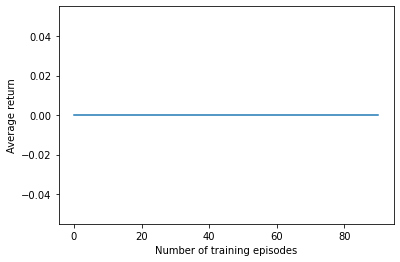

In [ ]:
#@title Run Reinforce Algorithm(small environment) { form-width: "30%" }

num_episodes = 100
num_eval_episodes = 10
eval_every_N = 10

env = Maze(Small_TXT_TEMPLATE)
deep_agent = REINFORCEAgent(
    env=env, gamma=.9, learning_rate=3e-4, steps_between_updates=4,
)

state = env.reset()
h, w, c = state.shape

def run_dqn_episode(deep_agent: REINFORCEAgent, env: Maze, eval: bool, max_steps: int = 1000, render = False) -> float:
  # Reset any counts and start the environment.
  state = env.reset().copy()
  deep_agent.first_observe(state)
  num_steps = 0

  deep_agent.reset_count()
  # Run an episode.
  while True:
    if render:
      print(env.render())

    # Generate an action from the agent's policy and step the environment.
    action = deep_agent.act(state, eval)
    next_state, reward, done = env.step(action)
    if not eval:
      if np.all(np_to_hash(next_state) == np_to_hash(state)):
        reward -= 5
      deep_agent.observe(state.copy(), action, reward, done)
    num_steps += 1
    state = next_state.copy()

    if not eval:
      if done:
        state = env.reset().copy()
        deep_agent.first_observe(state)
        deep_agent.reset_count()
              
      if num_steps > max_steps:
        break
    else:
      if num_steps > max_steps or done:
        break
  return reward


print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")

episodes = []
all_rewards = []
for episode in range(num_episodes):
  run_dqn_episode(deep_agent, env, eval=False, max_steps = 1000)

  if episode % eval_every_N == 0:
    reward = np.mean([run_dqn_episode(deep_agent, env, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)

#A2C(failure)

In [ ]:
#@title One step TD
def one_step_temporal_difference(values: chex.Array,
                  rewards: chex.Array,
                  dones: chex.Array,
                  gamma: float,
                  ) -> chex.Array:
  C = rewards + gamma * jax.lax.stop_gradient(values[1:] * (1-dones)) - values[:-1]
  return C

In [ ]:
#@title Catch network
def policy_network(x: chex.Array, env) -> chex.Array:
  out = hk.Flatten()(x[...,[1,2]])
  out = jax.nn.relu(hk.Linear(128)(out))
  out = hk.Linear(env.num_actions())(out)
  return jax.nn.softmax(out, axis=-1)

def value_network(x: chex.Array, env):
  out = hk.Flatten()(x[...,[1,2]])
  out = jax.nn.relu(hk.Linear(128)(out))
  out = hk.Linear(1)(out)
  return jnp.tanh(out)

In [ ]:
#@title A2CAgent { form-width: "30%" }
from typing import *
from collections import deque
import scipy

@chex.dataclass
class LearnerState:
  policy_params: hk.Params
  value_params: hk.Params
  policy_opt_state: optax.OptState
  value_opt_state: optax.OptState

class A2CAgent:
  def __init__(
      self,
      env,
      gamma: float,
      learning_rate: float,
      steps_between_updates: int,
      eps: float = 0.2,
      seed: int = 0,
      ) -> None:
    """Constructor.

    Args:
      env: input Catch environment.
      gamma: discount factor.
      learning_rate: learning rate when training the neural network.
      steps_between_updates: number of step between each update of the network.
      seed: seed of the random generator.
    """
    # Basic parameters
    self._env = env
    self._Na = env.num_actions()
    self._learning_rate = learning_rate
    self._gamma = gamma
    self._eps = eps

    # The agent is not updated at every step.
    self._steps_between_updates = steps_between_updates
    self._step = 0

    # Initialize the random generator
    self._rng = jax.random.PRNGKey(seed)
    self._rng, init_rng = jax.random.split(self._rng)

    # Initialize the network function
    self._policy_init, self._policy_apply = hk.without_apply_rng(hk.transform(self._hk_policy_function))
    self._value_init, self._value_apply = hk.without_apply_rng(hk.transform(self._hk_value_function))
    # Jit both the forward pass and the update function for more efficiency
    self.policy_apply = jax.jit(self._policy_apply)
    self.value_apply = jax.jit(self._value_apply)
    self.update_fn = jax.jit(self._update_fn)

    # Initialize the parameters of the neural network as well as the optimizer
    self._learner_state = self._init_state(init_rng)

    # Small buffers to store trajectories
    self._states = deque([], steps_between_updates + 1)
    self._actions = deque([], steps_between_updates + 1)
    self._rewards = deque([], steps_between_updates + 1)
    self._dones = deque([], steps_between_updates + 1)

    self._state = None

    self._counting_values = {}
    self._step_in_an_episode = 0
    
  def _optimizer(self) -> optax.GradientTransformation:
    return optax.adam(learning_rate=self._learning_rate)

  def _hk_policy_function(self, state: chex.Array) -> chex.Array:
    return policy_network(state, self._env)

  def _hk_value_function(self, state: chex.Array) -> chex.Array:
    return value_network(state, self._env)

  def first_observe(self, state:chex.Array):
    self._state = state

  def observe(self,
              state_t: chex.Array,
              action_t: chex.Array,
              reward_t: chex.Array,
              done_t: chex.Array,
              ) -> Optional[chex.Array]:
    #reward shaping
    state_key = np_to_hash(self._state)
    if state_key not in self._counting_values:
      self._counting_values[state_key] = np.zeros(self._env.num_actions())
    reward_t += 0.2 - 2 * self._counting_values[state_key][action_t]/(self._counting_values[state_key][action_t] + 1)
    self._counting_values[state_key][action_t] += 1

    self._states.append(ProcessState(state_t))
    self._actions.append(action_t)
    self._rewards.append(reward_t)
    self._dones.append(done_t)
    self._step += 1
    do_update = self._step % self._steps_between_updates
    do_update = do_update and self._step >= self._steps_between_updates + 1

    if do_update:
      states = np.stack(self._states, axis=0)
      actions = np.stack(self._actions, axis=0)[:-1]
      rewards = np.stack(self._rewards, axis=0)[:-1]
      dones = np.stack(self._dones, axis=0)[:-1]

      loss, self._learner_state = self.update_fn(self._learner_state,
                              states,
                              actions,
                              rewards,
                              dones)
      return loss
    return None

  def _init_state(self, rng: chex.PRNGKey) -> LearnerState:
    """Initializes the parameter of the neural network and the optimizer."""
    state = self._env.reset()
    bstate = ProcessState(state[None])
    policy_params = self._policy_init(rng, bstate)
    value_params = self._value_init(rng, bstate)
    policy_opt_state = self._optimizer().init(policy_params)
    value_opt_state = self._optimizer().init(value_params)
    return LearnerState(policy_params=policy_params, value_params=value_params, policy_opt_state=policy_opt_state, value_opt_state=value_opt_state)

  def random_policy(self):
    return np.random.randint(self._Na)

  def act(self,
          state: chex.Array,
          eval: bool,
          ) -> chex.Array:
    """Pick the next action according to the learnt policy."""
    bstate = ProcessState(state[None])
    logit = self.policy_apply(self._learner_state.policy_params, bstate)[0]
    if eval:
      return jnp.argmax(logit)
    if self._step_in_an_episode < 50:
      self._step_in_an_episode += 1
      return self.random_policy()
    self._rng, rng = jax.random.split(self._rng)
    return jax.random.categorical(rng, logit)

  def losses_fn(
      self,
      policy_params: hk.Params,
      value_params: hk.Params,
      states: chex.Array,
      actions: chex.Array,
      rewards: chex.Array,
      dones: chex.Array,
      ) -> chex.Array:
      """Compute the loss function for REINFORCE.

      Args:
        params: network parameters.
        states: a tensor of shape (T+1, N_rows, N_cols) representing the states
          observed from time 0 to T. N_rows, and N_cols are respectively the
          number of rows and columns in the catch environment.
        actions: a tensor of shape (T,) giving the actions performed from time
          0 to T-1.
        rewards: a tensor of shape (T,) giving the rewards obtained from time
          0 to T-1.
        dones: a tensor of shape (T,) giving the 'end of episode status' from
        time 0 to T-1.
      Returns:
        training_loss
      """
      values = self._value_apply(value_params, states)[:,0]
      Td = one_step_temporal_difference(values, rewards, dones, self._gamma)
      logits = self._policy_apply(policy_params, states[:-1])
      log_probs = -jax.nn.log_softmax(logits, axis=-1)

      policy_loss = jnp.mean(jnp.array([log_probs[i,actions[i]] * Td[i] for i in range(len(actions))]))
      value_loss = jnp.mean(jnp.square(Td))
      return policy_loss, value_loss

  def _update_fn(self,
                 learner_state: LearnerState,
                 states: chex.Array,
                 actions: chex.Array,
                 rewards: chex.Array,
                 dones: chex.Array,
                 ) -> Tuple[chex.Array, LearnerState]:
    """Updates the network.

    Args:
      learner_state: network and optimizer parameters.
      states: a tensor of shape (T+1, N_rows, N_cols) representing the states
        observed from time 0 to T. N_rows, and N_cols are respectively the
        number of rows and columns in the catch environment.
      actions: a tensor of shape (T,) giving the actions performed from time
        0 to T-1.
      rewards: a tensor of shape (T,) giving the rewards obtained from time
        0 to T-1.
      dones: a tensor of shape (T,) giving the 'end of episode status' from time
        0 to T-1.
    Returns:
      training_loss, next network ann optimizer's parameters
    """
    def _policy_loss(*args, **kwargs):
      return self.losses_fn(*args, **kwargs)[0]

    def _value_loss(*args, **kwargs):
      return self.losses_fn(*args, **kwargs)[1]

    policy_loss, policy_grad = jax.value_and_grad(_policy_loss)(learner_state.policy_params, learner_state.value_params, states, actions, rewards, dones)
    value_loss, value_grad = jax.value_and_grad(_value_loss, argnums=1)(learner_state.policy_params, learner_state.value_params, states, actions, rewards, dones) # important to add argnum

    policy_updates, policy_new_opt_state = self._optimizer().update(policy_grad, learner_state.policy_opt_state)
    value_updates, value_new_opt_state = self._optimizer().update(value_grad, learner_state.value_opt_state)
    new_policy_params = optax.apply_updates(learner_state.policy_params, policy_updates)
    new_value_params = optax.apply_updates(learner_state.value_params, value_updates)
    next_state = LearnerState(policy_params = new_policy_params, value_params = new_value_params, policy_opt_state = policy_new_opt_state, value_opt_state = value_new_opt_state)
    
    loss = policy_loss + value_loss
    return loss, next_state

  def reset(self):
    self._counting_values = {}
    self._step_in_an_episode = 0
    

Episode number:	| Average reward on 10 eval episodes
------------------------------------------------------
	0	|	0.0
	10	|	0.0
	20	|	0.0
	30	|	0.0
	40	|	0.0
	50	|	0.0
	60	|	0.0
	70	|	0.0
	80	|	0.0
	90	|	0.0
	100	|	0.0
	110	|	0.0
	120	|	0.0
	130	|	0.0
	140	|	0.0
	150	|	0.0
	160	|	0.0
	170	|	0.0
	180	|	0.0
	190	|	0.0
	200	|	0.0
	210	|	0.0
	220	|	0.0
	230	|	0.0
	240	|	0.0
	250	|	0.0
	260	|	0.0
	270	|	0.0
	280	|	0.0
	290	|	0.0
	300	|	0.0
	310	|	0.0
	320	|	0.0
	330	|	0.0
	340	|	0.0
	350	|	0.0
	360	|	0.0
	370	|	0.0
	380	|	0.0
	390	|	0.0
	400	|	0.0
	410	|	0.0
	420	|	0.0
	430	|	0.0
	440	|	0.0
	450	|	0.0
	460	|	0.0
	470	|	0.0
	480	|	0.0
	490	|	0.0


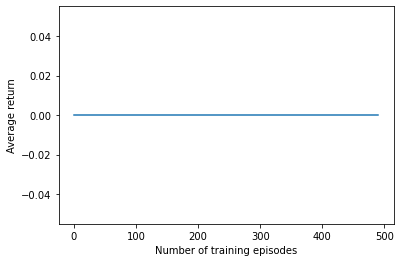

In [ ]:
#@title Run A2C Algorithm { form-width: "30%" }

num_episodes = 500
num_eval_episodes = 10
eval_every_N = 10

env = Maze(Small_TXT_TEMPLATE)
deep_agent = A2CAgent(
    env=env, gamma=1., learning_rate=1e-4, steps_between_updates=4,
)

state = env.reset()
h, w, c = state.shape

def run_dqn_episode(deep_agent: A2CAgent, env: Maze, eval: bool, max_steps: int = h*w, render = False) -> float:
  # Reset any counts and start the environment.
  state = env.reset().copy()
  deep_agent.first_observe(state)
  num_steps = 0

  deep_agent.reset()
  # Run an episode.
  while True:
    if render:
        print(env.render())
    # Generate an action from the agent's policy and step the environment.
    action = deep_agent.act(state, eval)
    next_state, reward, done = env.step(action)
    if not eval:
      if np.all(np_to_hash(next_state) == np_to_hash(state)):
        reward -= 2
      deep_agent.observe(state.copy(), action, reward, done)
    num_steps += 1
    state = next_state.copy()

    if not eval:
      if done:
        state = env.reset().copy()
        deep_agent.first_observe(state)
        deep_agent.reset()
              
      if num_steps > max_steps:
        break
    else:
      if num_steps > max_steps or done:
        break

  return reward


print(f"Episode number:\t| Average reward on {num_eval_episodes} eval episodes")
print("------------------------------------------------------")

episodes = []
all_rewards = []
for episode in range(num_episodes):
  run_dqn_episode(deep_agent, env, eval=False, max_steps = 200)

  if episode % eval_every_N == 0:
    reward = np.mean([run_dqn_episode(deep_agent, env, eval=True) for _ in range(num_eval_episodes)])
    print(f"\t{episode}\t|\t{reward}")
    all_rewards.append(reward)
    episodes.append(episode)

plt.xlabel('Number of training episodes')
plt.ylabel('Average return')
plt.plot(episodes, all_rewards)